In [1]:
#IBL SWR detector
import os
import re
import subprocess
import numpy as np
import pandas as pd
from scipy import io, signal, stats
from scipy.signal import lfilter
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import ripple_detection
from ripple_detection import filter_ripple_band
import ripple_detection.simulate as ripsim # for making our time vectors
from tqdm import tqdm
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions
import spikeglx
from brainbox.io.one import load_channel_locations
from brainbox.io.spikeglx import Streamer
from brainbox.io.one import SpikeSortingLoader
from neurodsp.voltage import destripe_lfp
from ibllib.plots import Density
import time 
import traceback
import logging
import logging.handlers
import sys
from fitter import Fitter, get_common_distributions, get_distributions
import pickle
from one.api import ONE


ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

/home/acampbell/miniconda3/envs/ONE_ibl_env/lib/python3.10/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
  warn(


## Mouse information

In [2]:
# https://pypi.org/project/ndx-ibl-metadata/
from ndx_ibl_metadata import IblSessionData, IblSubject, IblProbes

In [3]:
ibl_ripples_path =  '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024'
ibl_lfp_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024_lfp_data'

In [4]:
eventspersession_df = pd.read_csv(os.path.join(ibl_ripples_path, 'eventspersession_df.csv'), compression='gzip')
eventspersession_df.head()

session_id                              probe_id  \
0  0cc486c3-8c7b-494d-aa04-b70e2690bcba  db2100c3-64ac-463e-97a1-20ce8266cd5f   
1  746d1902-fa59-4cab-b0aa-013be36060d5  e31b4e39-e350-47a9-aca4-72496d99ff2a   
2  6a601cc5-7b79-4c75-b0e8-552246532f82  532bb33e-f22f-454a-ba1f-561d1578b250   
3  edd22318-216c-44ff-bc24-49ce8be78374  30ac1320-d671-46fc-87ef-875cdfc6b4eb   
4  6c6983ef-7383-4989-9183-32b1a300d17a  c0c3c95d-43c3-4e30-9ce7-0519d0473911   

   ripple_number  
0            259  
1            798  
2           1025  
3            974  
4           1317

In [5]:
import pandas as pd

seshID_list = []
age_weeks = []
sex = []
strain = []
genotype = []  
source = []
numper_of_probes = []
for sessionfolder in os.listdir(ibl_ripples_path):
    try:
        if '.csv' in sessionfolder:
            continue 
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        numper_of_probes.append(str(sum('karlsson' in filename for filename in folderfiles)))
        session_id = sessionfolder.split('_')[-1]
        seshID_list.append(str(session_id))
        session_info = one.alyx.rest(f'sessions/{session_id}','list')
        subject_table = one.alyx.rest('subjects/' + session_info['subject'],'list')
        age_weeks.append(str(int(subject_table['age_weeks']/7)))
        sex.append(str(subject_table['sex']))
        strain.append(str(subject_table['strain']))
        genotype.append(str(subject_table['genotype']))
        source.append(str(subject_table['source']))
    except:
        session_failed.append(session_id)

# Create a DataFrame
df = pd.DataFrame({
    'session_id': seshID_list,
    'age_weeks': age_weeks,
    'sex': sex,
    'strain': strain,
    'genotype': genotype,
    'source': source,
    'number_of_probes': numper_of_probes
})

# Print the number of unique values in each column
for column in df.columns:
    print(f"{column}: {df[column].nunique()}")
    print(df[column].value_counts().head(10))

session_id: 161
0cc486c3-8c7b-494d-aa04-b70e2690bcba    1
a82800ce-f4e3-4464-9b80-4c3d6fade333    1
bb6a5aae-2431-401d-8f6a-9fdd6de655a9    1
56956777-dca5-468c-87cb-78150432cc57    1
5339812f-8b91-40ba-9d8f-a559563cc46b    1
6713a4a7-faed-4df2-acab-ee4e63326f8d    1
642c97ea-fe89-4ec9-8629-5e492ea4019d    1
27ef44c0-acb2-4220-b776-477d0d5abd35    1
64977c74-9c04-437a-9ea1-50386c4996db    1
91bac580-76ed-41ab-ac07-89051f8d7f6e    1
Name: session_id, dtype: int64
age_weeks: 26
36    27
34    16
31    16
30    10
29    10
37     8
25     7
21     7
26     6
35     6
Name: age_weeks, dtype: int64
sex: 2
M    108
F     53
Name: sex, dtype: int64
strain: 1
None    161
Name: strain, dtype: int64
genotype: 1
[]    161
Name: genotype, dtype: int64
source: 1
None    161
Name: source, dtype: int64
number_of_probes: 2
1    136
2     25
Name: number_of_probes, dtype: int64


In [6]:
from math import floor

# Assuming karlsson_count_per_mouse is a dictionary with session_id as keys and counts as values
# Adjust the logic if session_id does not uniquely identify mice

for session_id, row in df.iterrows():
    print(f"Session ID: {row['session_id']}")
    print(f"Genotype: {row['genotype']}")
    print(f"Age (Weeks): {floor(int(row['age_weeks']))}")
    print(f"Sex: {row['sex']}")
    # Assuming session_id can be used to get karlsson count, adjust if necessary
    print(f"Probes in CA1 count: {row['number_of_probes']}\n")

Session ID: 0cc486c3-8c7b-494d-aa04-b70e2690bcba
Genotype: []
Age (Weeks): 28
Sex: M
Probes in CA1 count: 1

Session ID: 746d1902-fa59-4cab-b0aa-013be36060d5
Genotype: []
Age (Weeks): 30
Sex: M
Probes in CA1 count: 1

Session ID: 6a601cc5-7b79-4c75-b0e8-552246532f82
Genotype: []
Age (Weeks): 34
Sex: M
Probes in CA1 count: 1

Session ID: edd22318-216c-44ff-bc24-49ce8be78374
Genotype: []
Age (Weeks): 34
Sex: F
Probes in CA1 count: 1

Session ID: 6c6983ef-7383-4989-9183-32b1a300d17a
Genotype: []
Age (Weeks): 31
Sex: M
Probes in CA1 count: 1

Session ID: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
Genotype: []
Age (Weeks): 31
Sex: M
Probes in CA1 count: 1

Session ID: 5386aba9-9b97-4557-abcd-abc2da66b863
Genotype: []
Age (Weeks): 36
Sex: F
Probes in CA1 count: 1

Session ID: c6db3304-c906-400c-aa0f-45dd3945b2ea
Genotype: []
Age (Weeks): 34
Sex: M
Probes in CA1 count: 1

Session ID: a2701b93-d8e1-47e9-a819-f1063046f3e7
Genotype: []
Age (Weeks): 18
Sex: M
Probes in CA1 count: 1

Session ID: 3e6a97d

In [7]:
import pandas as pd
from math import floor

import pandas as pd
from math import floor

def summarize_data(df):
    # Initialize dictionaries to store the data
    summary = {'M': {'count': 0, 'ages': [], 'probes': []},
               'F': {'count': 0, 'ages': [], 'probes': []}}

    # Process each row in the dataframe
    for _, row in df.iterrows():
        sex = row['sex']
        age = floor(float(row['age_weeks']))
        
        # Convert probe count to float, skip if not possible
        try:
            probes = float(row['number_of_probes'])
        except ValueError:
            continue  # Skip this row if probe count is not a number

        summary[sex]['count'] += 1
        summary[sex]['ages'].append(age)
        summary[sex]['probes'].append(probes)

    # Calculate statistics
    result = []
    for sex in ['M', 'F']:
        data = summary[sex]
        if data['count'] > 0:
            avg_age = sum(data['ages']) / data['count']
            age_range = f"{min(data['ages'])}-{max(data['ages'])}"
            avg_probes = sum(data['probes']) / data['count']
            result.append({
                'Sex': sex,
                'Count': data['count'],
                'Avg Age': round(avg_age, 1),
                'Age Range': age_range,
                'Avg Probes': round(avg_probes, 2)
            })

    # Create a DataFrame from the results
    result_df = pd.DataFrame(result)

    return result_df

# Assuming 'df' is your original dataframe
summary_df = summarize_data(df)

# Print the summary dataframe
print(summary_df)

# Convert to LaTeX table
def dataframe_to_latex(df):
    latex_table = df.to_latex(index=False, escape=False)
    return latex_table

latex_table = dataframe_to_latex(summary_df)
print(latex_table)
# You can now use this summary_df to create your LaTeX table

  Sex  Count  Avg Age Age Range  Avg Probes
0   M    108     28.5     10-38        1.12
1   F     53     29.4     12-39        1.23
\begin{tabular}{lrrlr}
\toprule
Sex &  Count &  Avg Age & Age Range &  Avg Probes \\
\midrule
  M &    108 &     28.5 &     10-38 &        1.12 \\
  F &     53 &     29.4 &     12-39 &        1.23 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_15674/105473739.py:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=False, escape=False)


In [8]:
df

session_id age_weeks sex strain genotype  \
0    0cc486c3-8c7b-494d-aa04-b70e2690bcba        28   M   None       []   
1    746d1902-fa59-4cab-b0aa-013be36060d5        30   M   None       []   
2    6a601cc5-7b79-4c75-b0e8-552246532f82        34   M   None       []   
3    edd22318-216c-44ff-bc24-49ce8be78374        34   F   None       []   
4    6c6983ef-7383-4989-9183-32b1a300d17a        31   M   None       []   
..                                    ...       ...  ..    ...      ...   
156  38d95489-2e82-412a-8c1a-c5377b5f1555        37   M   None       []   
157  280ee768-f7b8-4c6c-9ea0-48ca75d6b6f3        31   M   None       []   
158  4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b        36   M   None       []   
159  a8a8af78-16de-4841-ab07-fde4b5281a03        36   F   None       []   
160  c557324b-b95d-414c-888f-6ee1329a2329        31   M   None       []   

    source number_of_probes  
0     None                1  
1     None                1  
2     None                1  
3     None                1  
4     None                1  
..     ...              ...  
156   None                1  
157   None                1  
158   None                1  
159   None                2  
160   None                1  

[161 rows x 7 columns]

In [9]:
# Create separate dataframes for each sex
df_m = df[df['sex'] == 'M']
df_f = df[df['sex'] == 'F']

# Run the loop for 'sex = M'
print("For 'sex = M':")
for column in df_m.columns:
    if column == 'session_id':
        continue
    print(f"{column}")
    print(df_m[column].value_counts().head(10))

# Run the loop for 'sex = F'
print("\nFor 'sex = F':")
for column in df_f.columns:
    if column == 'session_id':
        continue
    print(f"{column}")
    print(df_f[column].value_counts().head(10))

For 'sex = M':
age_weeks
36    15
31    15
34    10
21     7
30     7
25     6
26     5
35     5
28     4
22     4
Name: age_weeks, dtype: int64
sex
M    108
Name: sex, dtype: int64
strain
None    108
Name: strain, dtype: int64
genotype
[]    108
Name: genotype, dtype: int64
source
None    108
Name: source, dtype: int64
number_of_probes
1    95
2    13
Name: number_of_probes, dtype: int64

For 'sex = F':
age_weeks
36    12
34     6
29     6
19     5
37     5
20     3
30     3
12     2
31     1
26     1
Name: age_weeks, dtype: int64
sex
F    53
Name: sex, dtype: int64
strain
None    53
Name: strain, dtype: int64
genotype
[]    53
Name: genotype, dtype: int64
source
None    53
Name: source, dtype: int64
number_of_probes
1    41
2    12
Name: number_of_probes, dtype: int64


## Number of ripples by thresholds

In [10]:
minpeak2p5_nogamma = []
minpeak3_nogamma = []
minpeak5_nogamma = []
minpeak2p5_gamma = []
minpeak3_gamma = []
minpeak5_gamma = []
seshIDs = []
failed_sesh = []
absent_gamma = []
absent_nogamma = []

for sessionfolder in os.listdir(ibl_ripples_path):
    session_id = sessionfolder.split('_')[-1]
    try:
        if '.csv' in sessionfolder:
            continue
        
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        global_swrs_gamma_file = [file for file in folderfiles if 'global_swrs_no_movement.csv' in file][0]
        global_swrs_nogamma_file = [file for file in folderfiles if 'global_swrs_no_movement_no_gamma.csv' in file][0]
        rips_gamma_df = pd.read_csv(os.path.join(folder_path, global_swrs_gamma_file), compression = 'gzip')
        rips_nogamma_df = pd.read_csv(os.path.join(folder_path, global_swrs_nogamma_file), compression = 'gzip')
        minpeak2p5_nogamma.append(rips_nogamma_df[rips_nogamma_df.global_max_zscore > 2.5].shape[0])
        minpeak3_nogamma.append(rips_nogamma_df[rips_nogamma_df.global_max_zscore > 3].shape[0])
        minpeak5_nogamma.append(rips_nogamma_df[rips_nogamma_df.global_max_zscore > 5].shape[0])
        minpeak2p5_gamma.append(rips_gamma_df[rips_gamma_df.global_max_zscore > 2.5].shape[0])
        minpeak3_gamma.append(rips_gamma_df[rips_gamma_df.global_max_zscore > 3].shape[0])
        minpeak5_gamma.append(rips_gamma_df[rips_gamma_df.global_max_zscore > 5].shape[0])
        seshIDs.append(str(session_id))
    except:
        failed_sesh.append(session_id)
        print(f'failed session {session_id}')
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        if not any('global_swrs_no_movement_no_gamma.csv' in file for file in folderfiles):
            print(f"Absent no_movement_no_gamma file for session {session_id}")
            absent_nogamma.append(session_id)
        if not any('global_swrs_no_movement.csv' in file for file in folderfiles):
            print(f"Absent no_movement file for session {session_id}")
            absent_gamma.append(session_id)
        print(traceback.format_exc())
        continue

print(len(minpeak2p5_nogamma))
print(len(minpeak3_nogamma))
print(len(minpeak5_nogamma))
print(len(minpeak2p5_gamma))
print(len(minpeak3_gamma))
print(len(minpeak5_gamma))
print(len(seshIDs))
print(len(failed_sesh))
print(len(absent_gamma))
print(len(absent_nogamma))
    
ibl_summary_ripnum_df = pd.DataFrame({
    'Session_ID': seshIDs,
    'Min_Peak_2.5_NoGamma': minpeak2p5_nogamma,
    'Min_Peak_3_NoGamma': minpeak3_nogamma,
    'Min_Peak_5_NoGamma': minpeak5_nogamma,
    'Min_Peak_2.5_Gamma': minpeak2p5_gamma,
    'Min_Peak_3_Gamma': minpeak3_gamma,
    'Min_Peak_5_Gamma': minpeak5_gamma
})

failed session caa5dddc-9290-4e27-9f5e-575ba3598614
Absent no_movement_no_gamma file for session caa5dddc-9290-4e27-9f5e-575ba3598614
Absent no_movement file for session caa5dddc-9290-4e27-9f5e-575ba3598614
Traceback (most recent call last):
  File "/tmp/ipykernel_15674/1764892266.py", line 20, in <module>
    global_swrs_gamma_file = [file for file in folderfiles if 'global_swrs_no_movement.csv' in file][0]
IndexError: list index out of range

160
160
160
160
160
160
160
1
1
1


In [11]:
ibl_column_sums = ibl_summary_ripnum_df.drop('Session_ID', axis=1).sum()
ibl_column_sums

Min_Peak_2.5_NoGamma    243876
Min_Peak_3_NoGamma      219177
Min_Peak_5_NoGamma       82632
Min_Peak_2.5_Gamma      283523
Min_Peak_3_Gamma        257254
Min_Peak_5_Gamma        106658
dtype: int64

In [12]:
del folder_path

In [13]:
sessionfolder

'swrs_session_c557324b-b95d-414c-888f-6ee1329a2329'

In [14]:
folderfiles

['probe_d8dae4d0-e11d-4b4d-8bd9-103c13491eb7_channel_channelsrawInd_76_movement_artifacts.csv',
 'session_c557324b-b95d-414c-888f-6ee1329a2329_putative_global_swrs_no_movement.csv',
 'session_c557324b-b95d-414c-888f-6ee1329a2329_putative_global_swrs_no_movement_no_gamma.csv',
 'probe_d8dae4d0-e11d-4b4d-8bd9-103c13491eb7_channel_channelsrawInd_220_karlsson_detector_events.csv',
 'probe_d8dae4d0-e11d-4b4d-8bd9-103c13491eb7_channel_channelsrawInd_66_movement_artifacts.csv',
 'probe_d8dae4d0-e11d-4b4d-8bd9-103c13491eb7_channel_channelsrawInd_220_gamma_band_events.csv']

In [15]:
# for the abi visual coding
abi_viscoding_ripples_path = '/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024'

minpeak2p5_nogamma = []
minpeak3_nogamma = []
minpeak5_nogamma = []
minpeak2p5_gamma = []
minpeak3_gamma = []
minpeak5_gamma = []
seshIDs = []
failed_sesh = []
absent_gamma = []
absent_nogamma = []

for sessionfolder in os.listdir(abi_viscoding_ripples_path):
    session_id = sessionfolder.split('_')[-1]
    try:
        if '.csv' in sessionfolder:
            continue
        folder_path = os.path.join(abi_viscoding_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        global_swrs_gamma_file = [file for file in folderfiles if 'global_swrs_no_movement.csv' in file][0]
        global_swrs_nogamma_file = [file for file in folderfiles if 'global_swrs_no_movement_no_gamma.csv' in file][0]
        rips_gamma_df = pd.read_csv(os.path.join(folder_path, global_swrs_gamma_file), compression = 'gzip')
        rips_nogamma_df = pd.read_csv(os.path.join(folder_path, global_swrs_nogamma_file), compression = 'gzip')
        minpeak2p5_nogamma.append(rips_nogamma_df[rips_nogamma_df.global_max_zscore > 2.5].shape[0])
        minpeak3_nogamma.append(rips_nogamma_df[rips_nogamma_df.global_max_zscore > 3].shape[0])
        minpeak5_nogamma.append(rips_nogamma_df[rips_nogamma_df.global_max_zscore > 5].shape[0])
        minpeak2p5_gamma.append(rips_gamma_df[rips_gamma_df.global_max_zscore > 2.5].shape[0])
        minpeak3_gamma.append(rips_gamma_df[rips_gamma_df.global_max_zscore > 3].shape[0])
        minpeak5_gamma.append(rips_gamma_df[rips_gamma_df.global_max_zscore > 5].shape[0])
        seshIDs.append(str(session_id))
    except:
        failed_sesh.append(session_id)
        print(f'failed session {session_id}')
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        if not any('global_swrs_no_movement_no_gamma.csv' in file for file in folderfiles):
            print(f"Absent no_movement_no_gamma file for session {session_id}")
            absent_nogamma.append(session_id)
        if not any('global_swrs_no_movement.csv' in file for file in folderfiles):
            print(f"Absent no_movement file for session {session_id}")
            absent_gamma.append(session_id)
        print(traceback.format_exc())
        continue

print(len(minpeak2p5_nogamma))
print(len(minpeak3_nogamma))
print(len(minpeak5_nogamma))
print(len(minpeak2p5_gamma))
print(len(minpeak3_gamma))
print(len(minpeak5_gamma))
print(len(seshIDs))
print(len(failed_sesh))
print(len(absent_gamma))
print(len(absent_nogamma))
    
abi_viscoding_summary_ripnum_df = pd.DataFrame({
    'Session_ID': seshIDs,
    'Min_Peak_2.5_NoGamma': minpeak2p5_nogamma,
    'Min_Peak_3_NoGamma': minpeak3_nogamma,
    'Min_Peak_5_NoGamma': minpeak5_nogamma,
    'Min_Peak_2.5_Gamma': minpeak2p5_gamma,
    'Min_Peak_3_Gamma': minpeak3_gamma,
    'Min_Peak_5_Gamma': minpeak5_gamma
})

abi_viscoding_summary_ripnum_df.head()

47
47
47
47
47
47
47
0
0
0


Session_ID  Min_Peak_2.5_NoGamma  Min_Peak_3_NoGamma  Min_Peak_5_NoGamma  \
0  797828357                  6498                5929                2671   
1  821695405                  7971                7496                3692   
2  750749662                 13470               12480                5499   
3  816200189                 10132                9380                4510   
4  835479236                  6516                5653                2494   

   Min_Peak_2.5_Gamma  Min_Peak_3_Gamma  Min_Peak_5_Gamma  
0                6936              6370              3041  
1                8494              8032              4256  
2               13881             12872              5755  
3               10290              9550              4885  
4                6844              5980              2805

In [16]:
abi_viscoding_column_sums = abi_viscoding_summary_ripnum_df.drop('Session_ID', axis=1).sum()
abi_viscoding_column_sums

Min_Peak_2.5_NoGamma    387758
Min_Peak_3_NoGamma      349201
Min_Peak_5_NoGamma      142694
Min_Peak_2.5_Gamma      409057
Min_Peak_3_Gamma        370315
Min_Peak_5_Gamma        160661
dtype: int64

In [17]:
# for the abi visual behaviour 
abi_visbehave_ripples_path = '/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024'

minpeak2p5_nogamma = []
minpeak3_nogamma = []
minpeak5_nogamma = []
minpeak2p5_gamma = []
minpeak3_gamma = []
minpeak5_gamma = []
seshIDs = []
failed_sesh = []
absent_gamma = []
absent_nogamma = []

for sessionfolder in os.listdir(abi_visbehave_ripples_path):
    session_id = sessionfolder.split('_')[-1]
    try:
        if '.csv' in sessionfolder:
            continue
        
        folder_path = os.path.join(abi_visbehave_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        global_swrs_gamma_file = [file for file in folderfiles if 'global_swrs_no_movement.csv' in file][0]
        global_swrs_nogamma_file = [file for file in folderfiles if 'global_swrs_no_movement_no_gamma.csv' in file][0]
        rips_gamma_df = pd.read_csv(os.path.join(folder_path, global_swrs_gamma_file), compression = 'gzip')
        rips_nogamma_df = pd.read_csv(os.path.join(folder_path, global_swrs_nogamma_file), compression = 'gzip')
        minpeak2p5_nogamma.append(rips_nogamma_df[rips_nogamma_df.global_max_zscore > 2.5].shape[0])
        minpeak3_nogamma.append(rips_nogamma_df[rips_nogamma_df.global_max_zscore > 3].shape[0])
        minpeak5_nogamma.append(rips_nogamma_df[rips_nogamma_df.global_max_zscore > 5].shape[0])
        minpeak2p5_gamma.append(rips_gamma_df[rips_gamma_df.global_max_zscore > 2.5].shape[0])
        minpeak3_gamma.append(rips_gamma_df[rips_gamma_df.global_max_zscore > 3].shape[0])
        minpeak5_gamma.append(rips_gamma_df[rips_gamma_df.global_max_zscore > 5].shape[0])
        seshIDs.append(str(session_id))
    except:
        failed_sesh.append(session_id)
        print(f'failed session {session_id}')
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        if not any('global_swrs_no_movement_no_gamma.csv' in file for file in folderfiles):
            print(f"Absent no_movement_no_gamma file for session {session_id}")
            absent_nogamma.append(session_id)
        if not any('global_swrs_no_movement.csv' in file for file in folderfiles):
            print(f"Absent no_movement file for session {session_id}")
            absent_gamma.append(session_id)
        print(traceback.format_exc())
        continue

print(len(minpeak2p5_nogamma))
print(len(minpeak3_nogamma))
print(len(minpeak5_nogamma))
print(len(minpeak2p5_gamma))
print(len(minpeak3_gamma))
print(len(minpeak5_gamma))
print(len(seshIDs))
print(len(failed_sesh))
print(len(absent_gamma))
print(len(absent_nogamma))
    
abi_visbehave_summary_ripnum_df = pd.DataFrame({
    'Session_ID': seshIDs,
    'Min_Peak_2.5_NoGamma': minpeak2p5_nogamma,
    'Min_Peak_3_NoGamma': minpeak3_nogamma,
    'Min_Peak_5_NoGamma': minpeak5_nogamma,
    'Min_Peak_2.5_Gamma': minpeak2p5_gamma,
    'Min_Peak_3_Gamma': minpeak3_gamma,
    'Min_Peak_5_Gamma': minpeak5_gamma
})

abi_visbehave_summary_ripnum_df

99
99
99
99
99
99
99
0
0
0


Session_ID  Min_Peak_2.5_NoGamma  Min_Peak_3_NoGamma  Min_Peak_5_NoGamma  \
0   1118327332                 11971               10374                2503   
1   1120251466                  8745                7899                3095   
2   1130113579                 17440               15608                3987   
3   1118512505                 13484               12186                4150   
4   1108335514                 10484                9291                2095   
..         ...                   ...                 ...                 ...   
94  1125713722                 11169                9683                2052   
95  1093638203                  7923                6976                1866   
96  1104289498                  5727                5258                2736   
97  1140102579                 22177               19225                3223   
98  1081090969                 17500               15476                3575   

    Min_Peak_2.5_Gamma  Min_Peak_3_Gamma  Min_Peak_5_Gamma  
0                12251             10629              2634  
1                 8973              8129              3290  
2                17734             15892              4084  
3                13760             12442              4287  
4                10720              9509              2182  
..                 ...               ...               ...  
94               11436              9928              2219  
95                8036              7081              1907  
96                5944              5478              2975  
97               22547             19572              3345  
98               17766             15721              3640  

[99 rows x 7 columns]

In [18]:
abi_visbehave_column_sums = abi_visbehave_summary_ripnum_df.drop('Session_ID', axis=1).sum()
abi_visbehave_column_sums

Min_Peak_2.5_NoGamma    1333757
Min_Peak_3_NoGamma      1177840
Min_Peak_5_NoGamma       289577
Min_Peak_2.5_Gamma      1361441
Min_Peak_3_Gamma        1203921
Min_Peak_5_Gamma         302514
dtype: int64

Note that you can't really compare the global level event distributions between the ABI and IBL because the ABI just had more probes and greater probe density compared to the IBL.  There are alos far fewer mice in the ABI so the counts are going to be lower.  This plot is not that useful or informative.  The ABI by its nature is going to have much less mice.  A bar plot showing the varience might do better but again its not comperable cause its per mouse.

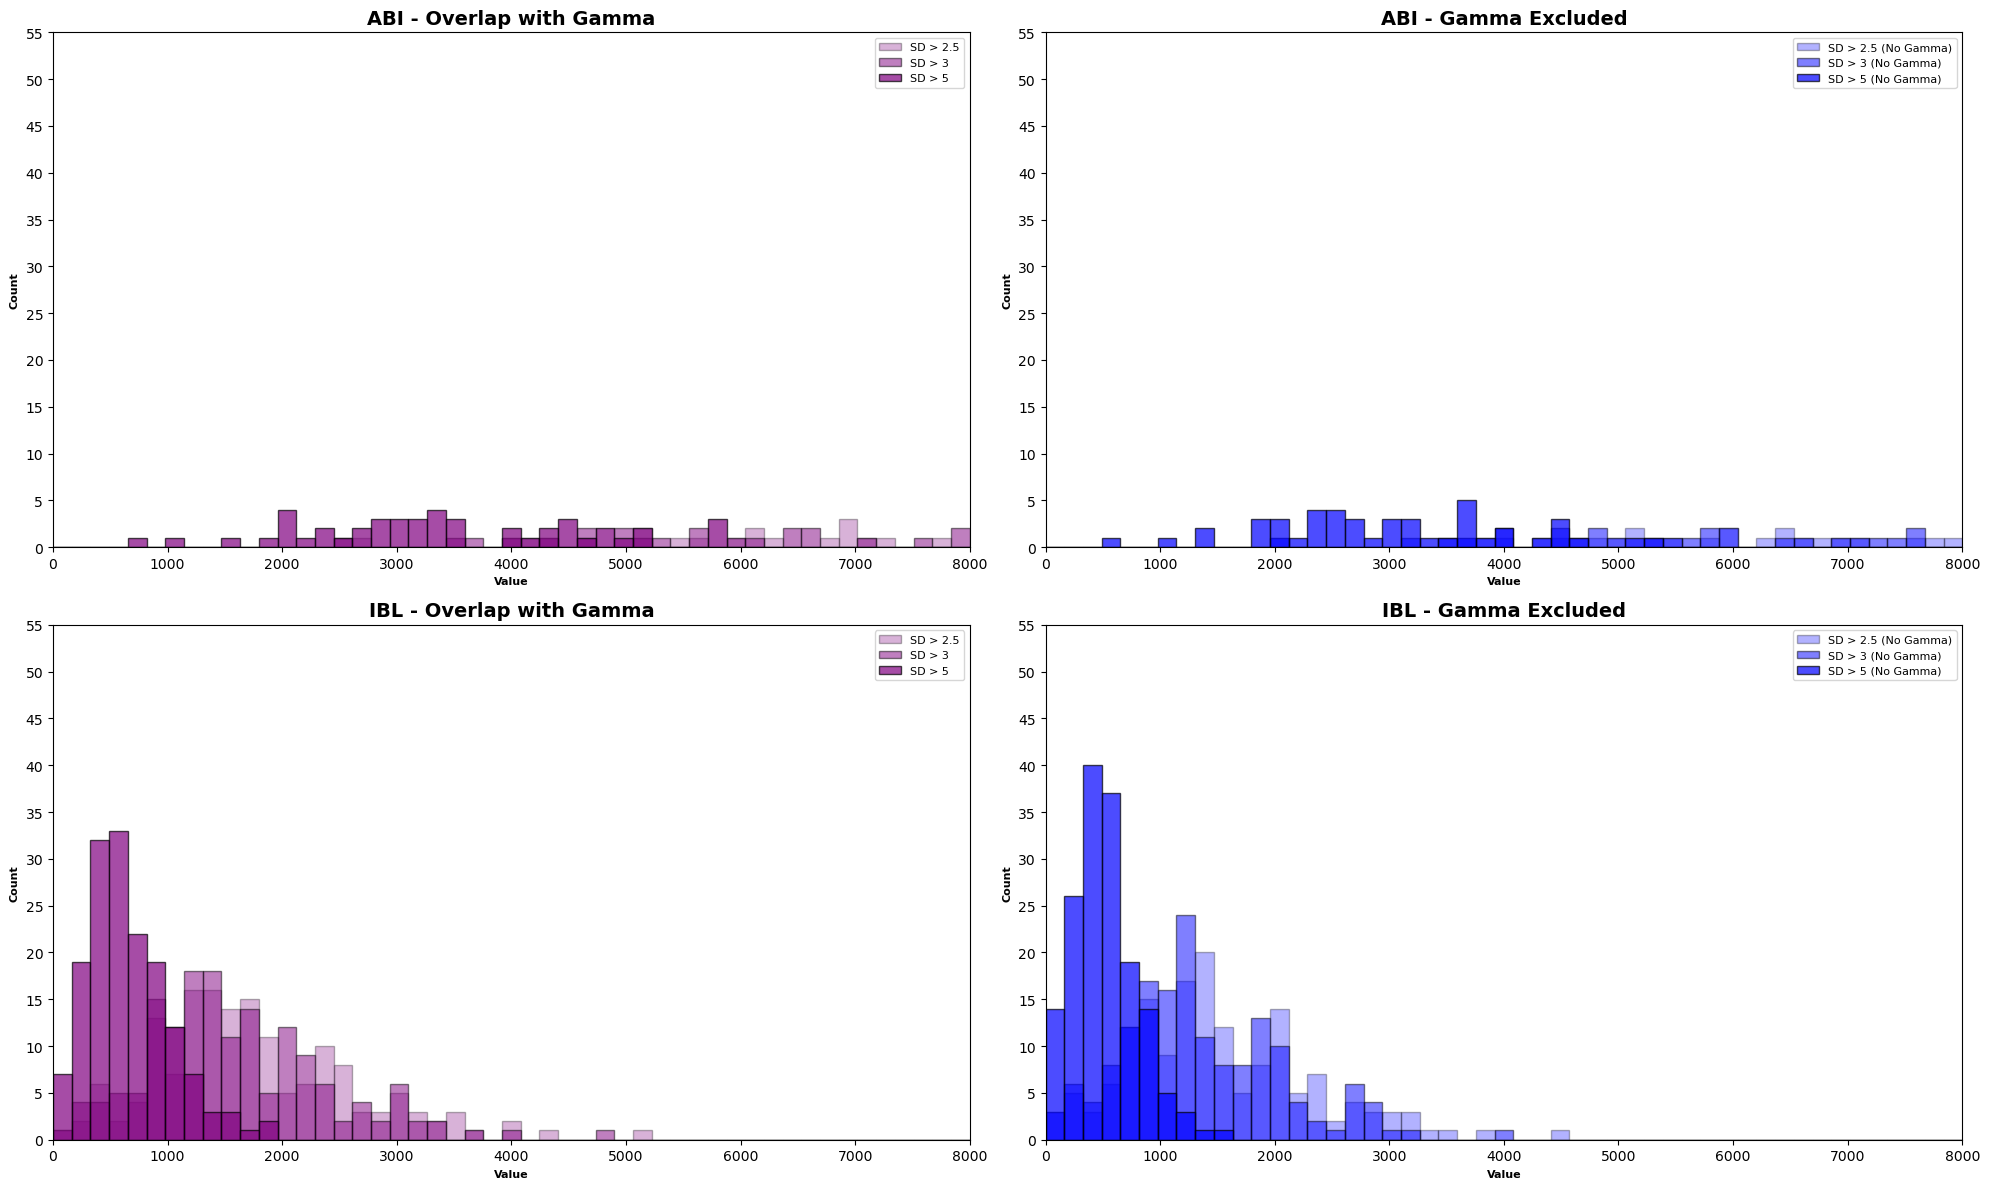

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define the columns and corresponding colors and opacities
columns = [['Min_Peak_2.5_Gamma', 'Min_Peak_3_Gamma', 'Min_Peak_5_Gamma'], ['Min_Peak_2.5_NoGamma', 'Min_Peak_3_NoGamma', 'Min_Peak_5_NoGamma']]
labels = [['SD > 2.5', 'SD > 3', 'SD > 5'], ['SD > 2.5 (No Gamma)', 'SD > 3 (No Gamma)', 'SD > 5 (No Gamma)']]
colors = ['purple', 'blue']
opacities = [0.3, 0.5, 0.7]

# Define the bin edges
bin_edges = np.linspace(0, 8000, 50)  # Creates 49 bins from 0 to 8000

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

for i, df in enumerate([abi_viscoding_summary_ripnum_df, ibl_summary_ripnum_df]):  # Use summary_ripnum_df for both
    for j, column_group in enumerate(columns):
        for k, column in enumerate(column_group):
            axs[i, j].hist(df[column].dropna(), bins=bin_edges, color=colors[j], alpha=opacities[k], label=labels[j][k], edgecolor='black')
        axs[i, j].set_xlabel('Value', fontsize=8, fontweight='bold')
        axs[i, j].set_ylabel('Count', fontsize=8, fontweight='bold')
        axs[i, j].set_xlim([0, 8000])
        axs[i, j].set_ylim([0, 35])
        axs[i, j].set_yticks(np.arange(0, 56, 5))  # Sets y-axis ticks in increments of 5
        axs[i, j].legend(fontsize=8)

axs[0, 0].set_title('ABI - Overlap with Gamma', fontsize=14, fontweight='bold')
axs[0, 1].set_title('ABI - Gamma Excluded', fontsize=14, fontweight='bold')
axs[1, 0].set_title('IBL - Overlap with Gamma', fontsize=14, fontweight='bold')
axs[1, 1].set_title('IBL - Gamma Excluded', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

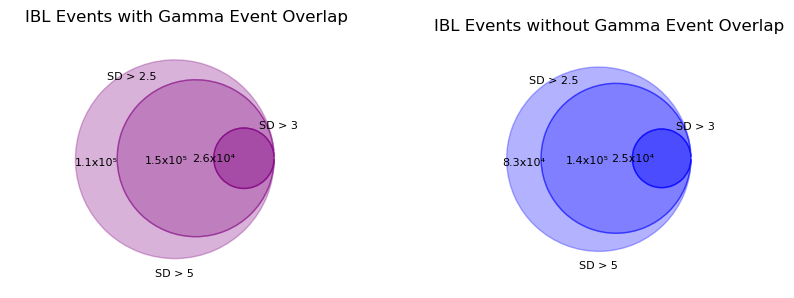

In [20]:
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import numpy as np

# Define the set sizes and the intersections
no_gamma = {'100': 0, '010': 0, '001': 82632, '110': 0, '101': 219177 - 82632, '011': 0, '111': 243876 - 219177}
gamma = {'100': 0, '010': 0, '001': 106658, '110': 0, '101': 257254 - 106658, '011': 0, '111': 283523 - 257254}

# Calculate the maximum area
max_area = max(sum(no_gamma.values()), sum(gamma.values()))

def set_venn_scale(vd, ax, true_area, reference_area=max_area):
    sx = np.sqrt(float(reference_area)/true_area)
    sy = max(vd.radii)*1.3
    ax.set_xlim(-sx, sx)
    ax.set_ylim(-sy, sy)

# Create the Venn diagrams
plt.figure(figsize=(10, 5))

plt.subplot(121)
venn = venn3(subsets=gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
#venn_circles = venn3_circles(subsets=gamma)
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('purple')
venn.get_patch_by_id('101').set_color('purple')
venn.get_patch_by_id('111').set_color('purple')
set_venn_scale(venn, plt.gca(), sum(gamma.values()))
plt.title('IBL Events with Gamma Event Overlap')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)

plt.subplot(122)
venn = venn3(subsets=no_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
#venn_circles = venn3_circles(subsets=no_gamma)
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('blue')
venn.get_patch_by_id('101').set_color('blue')
venn.get_patch_by_id('111').set_color('blue')
set_venn_scale(venn, plt.gca(), sum(no_gamma.values()))
plt.title('IBL Events without Gamma Event Overlap')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)

plt.show()

In [21]:
ibl_column_sums = ibl_summary_ripnum_df.drop('Session_ID', axis=1).sum()
ibl_column_sums

Min_Peak_2.5_NoGamma    243876
Min_Peak_3_NoGamma      219177
Min_Peak_5_NoGamma       82632
Min_Peak_2.5_Gamma      283523
Min_Peak_3_Gamma        257254
Min_Peak_5_Gamma        106658
dtype: int64

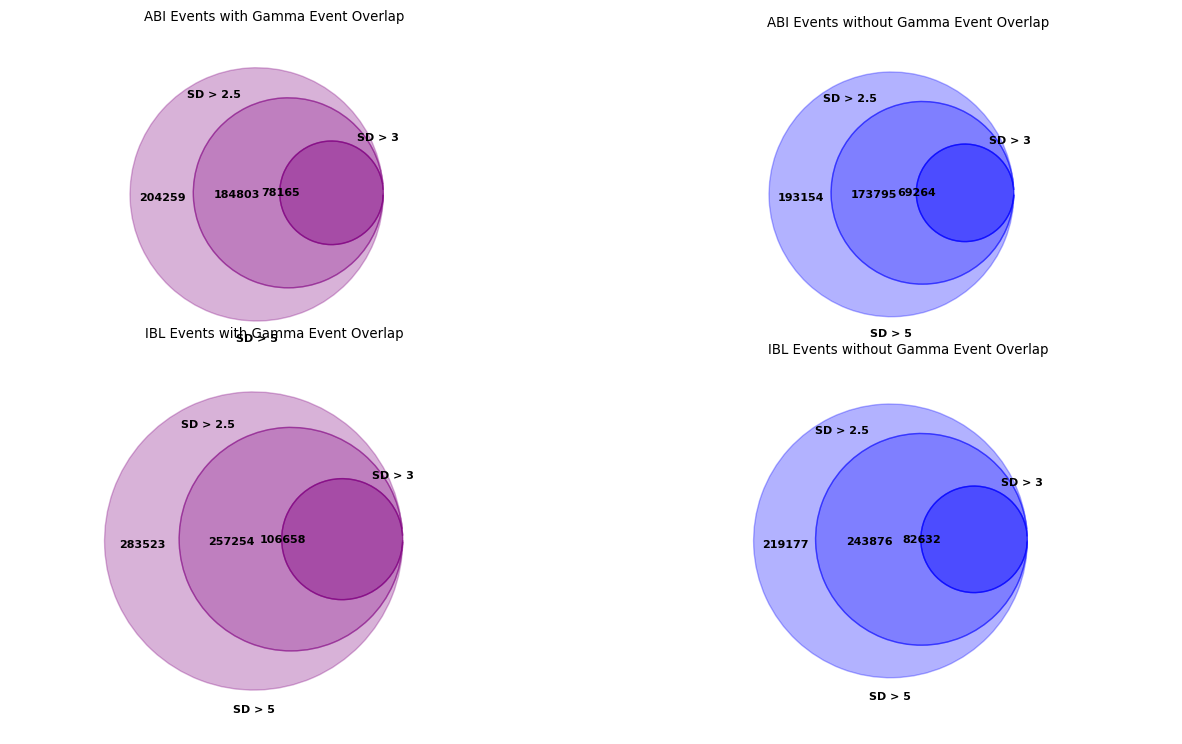

In [22]:
# GLOBAL EVENTS

from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import numpy as np

# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams['font.size'] = 8
plt.rcParams['font.weight'] = 'bold'


# Define the set sizes and the intersections
"""
ibl_no_gamma = {'100': 0, '010': 0, '001': 82632, '110': 0, '101': 219177 - 82632, '011': 0, '111': 243876 - 219177}
ibl_gamma = {'100': 0, '010': 0, '001': 106658, '110': 0, '101': 257254 - 106658, '011': 0, '111': 283523 - 257254}
abi_no_gamma = {'100': 0, '010': 0, '001': 69264, '110': 0, '101': 173795 - 69264, '011': 0, '111': 193154 - 173795}
abi_gamma = {'100': 0, '010': 0, '001': 78165, '110': 0, '101': 184803 - 78165, '011': 0, '111': 204259 - 184803}
"""
ibl_no_gamma = {'100': 0, '010': 0, '001': 219177, '110': 0, '101': 243876, '011': 0, '111': 82632}
ibl_gamma = {'100': 0, '010': 0, '001': 283523, '110': 0, '101': 257254, '011': 0, '111': 106658}
abi_no_gamma = {'100': 0, '010': 0, '001': 193154, '110': 0, '101': 173795, '011': 0, '111': 69264}
abi_gamma = {'100': 0, '010': 0, '001': 204259, '110': 0, '101': 184803, '011': 0, '111':  78165}


# Calculate the maximum area
max_area = max( sum(ibl_no_gamma.values()), sum(ibl_gamma.values()), sum(abi_no_gamma.values()), sum(abi_gamma.values()))

def set_venn_scale(vd, ax, true_area, reference_area=max_area):
    sx = np.sqrt(float(reference_area)/true_area)
    sy = max(vd.radii)*1.3
    ax.set_xlim(-sx, sx)
    ax.set_ylim(-sy, sy)

# Create the Venn diagrams
plt.figure(figsize=(15, 15))  # Increase the size of the figure

plt.subplot(121)
venn = venn3(subsets=abi_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('purple')
venn.get_patch_by_id('101').set_color('purple')
venn.get_patch_by_id('111').set_color('purple')
set_venn_scale(venn, plt.gca(), sum(abi_gamma.values()))
plt.title('ABI Events with Gamma Event Overlap')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)
        

plt.subplot(122)
venn = venn3(subsets=abi_no_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('blue')
venn.get_patch_by_id('101').set_color('blue')
venn.get_patch_by_id('111').set_color('blue')
set_venn_scale(venn, plt.gca(), sum(abi_no_gamma.values()))
plt.title('ABI Events without Gamma Event Overlap')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)

plt.subplot(223)
venn = venn3(subsets=ibl_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
#venn_circles = venn3_circles(subsets=gamma)
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('purple')
venn.get_patch_by_id('101').set_color('purple')
venn.get_patch_by_id('111').set_color('purple')
set_venn_scale(venn, plt.gca(), sum(ibl_gamma.values()))
plt.title('IBL Events with Gamma Event Overlap')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)

plt.subplot(224)
venn = venn3(subsets=ibl_no_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
#venn_circles = venn3_circles(subsets=no_gamma)
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('blue')
venn.get_patch_by_id('101').set_color('blue')
venn.get_patch_by_id('111').set_color('blue')
set_venn_scale(venn, plt.gca(), sum(ibl_no_gamma.values()))
plt.title('IBL Events without Gamma Event Overlap')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)
        

# After creating all the subplots
plt.subplots_adjust(hspace=0.5, wspace=0.2)  # Adjust the space between the subplots

# Create the Venn diagrams
#fig_width_mm = 110  # width in millimeters
#fig_height_mm = 92.5  # height in millimeters
#fig_width_in = fig_width_mm / 25.4  # convert to inches
#fig_height_in = fig_height_mm / 25.4  # convert to inches
#plt.figure(figsize=(fig_width_in, fig_height_in))  # set the figure size


plt.savefig('/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/ripplenumbervenn.svg', format='svg')  # Save the figure as an SVG file

plt.show()

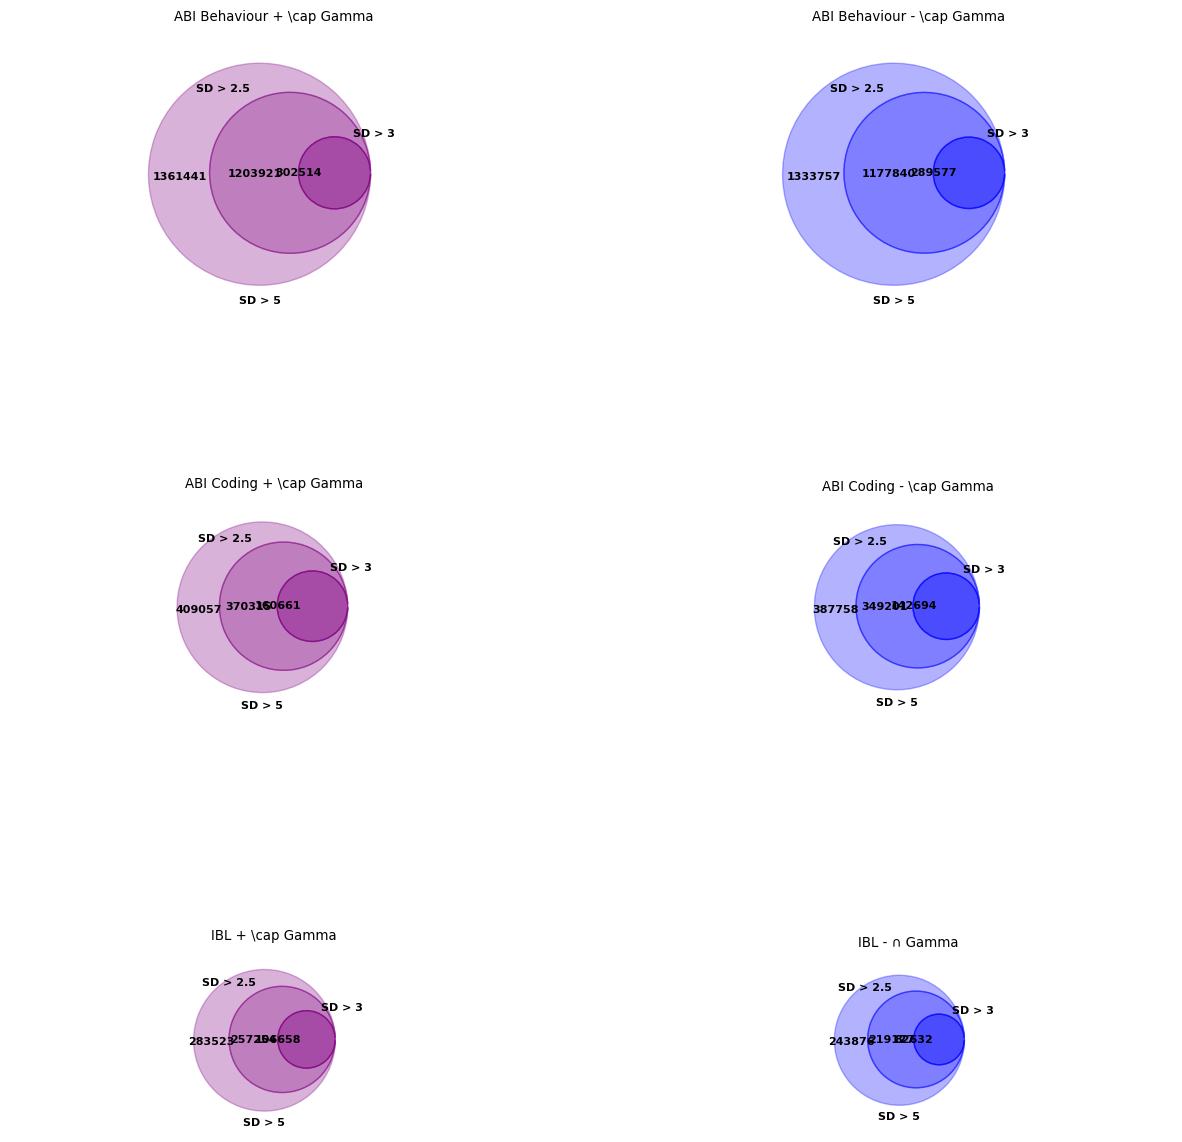

In [23]:
# GLOBAL EVENTS

from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import numpy as np

# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams['font.size'] = 8
plt.rcParams['font.weight'] = 'bold'


# Define the set sizes and the intersections
ibl_no_gamma = {'100': 0, '010': 0, '001': ibl_column_sums[0], '110': 0, '101': ibl_column_sums[1], '011': 0, '111': ibl_column_sums[2]}
ibl_gamma = {'100': 0, '010': 0, '001': ibl_column_sums[3], '110': 0, '101': ibl_column_sums[4], '011': 0, '111': ibl_column_sums[5]}
abi_viscoding_no_gamma = {'100': 0, '010': 0, '001': abi_viscoding_column_sums[0], '110': 0, '101': abi_viscoding_column_sums[1], '011': 0, '111': abi_viscoding_column_sums[2]}
abi_viscoding_gamma = {'100': 0, '010': 0, '001': abi_viscoding_column_sums[3], '110': 0, '101': abi_viscoding_column_sums[4], '011': 0, '111':  abi_viscoding_column_sums[5]}
abi_visbehave_no_gamma = {'100': 0, '010': 0, '001': abi_visbehave_column_sums[0], '110': 0, '101': abi_visbehave_column_sums[1], '011': 0, '111': abi_visbehave_column_sums[2]}
abi_visbehave_gamma = {'100': 0, '010': 0, '001': abi_visbehave_column_sums[3], '110': 0, '101': abi_visbehave_column_sums[4], '011': 0, '111':  abi_visbehave_column_sums[5]}



# Calculate the maximum area
max_area = max( sum(ibl_no_gamma.values()), sum(ibl_gamma.values()), 
               sum(abi_viscoding_no_gamma.values()), sum(abi_viscoding_gamma.values()),
               sum(abi_visbehave_no_gamma.values()),sum(abi_visbehave_gamma.values()))

def set_venn_scale(vd, ax, true_area, reference_area=max_area):
    sx = np.sqrt(float(reference_area)/true_area)
    sy = max(vd.radii)*1.3
    ax.set_xlim(-sx, sx)
    ax.set_ylim(-sy, sy)

# Create the Venn diagrams
plt.figure(figsize=(15, 15))  # Increase the size of the figure

plt.subplot(321)
venn = venn3(subsets=abi_visbehave_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
#venn_circles = venn3_circles(subsets=gamma)
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('purple')
venn.get_patch_by_id('101').set_color('purple')
venn.get_patch_by_id('111').set_color('purple')
set_venn_scale(venn, plt.gca(), sum(abi_visbehave_gamma.values()))
plt.title('ABI Behaviour + \cap Gamma')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)


plt.subplot(322)

venn = venn3(subsets=abi_visbehave_no_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
#venn_circles = venn3_circles(subsets=no_gamma)
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('blue')
venn.get_patch_by_id('101').set_color('blue')
venn.get_patch_by_id('111').set_color('blue')
set_venn_scale(venn, plt.gca(), sum(abi_visbehave_no_gamma.values()))
plt.title('ABI Behaviour - \cap Gamma')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)

plt.subplot(323)

venn = venn3(subsets=abi_viscoding_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('purple')
venn.get_patch_by_id('101').set_color('purple')
venn.get_patch_by_id('111').set_color('purple')
set_venn_scale(venn, plt.gca(), sum(abi_viscoding_gamma.values()))
plt.title('ABI Coding + \cap Gamma')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)

plt.subplot(324)

venn = venn3(subsets=abi_viscoding_no_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('blue')
venn.get_patch_by_id('101').set_color('blue')
venn.get_patch_by_id('111').set_color('blue')
set_venn_scale(venn, plt.gca(), sum(abi_viscoding_no_gamma.values()))
plt.title('ABI Coding - \cap Gamma')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)
        

plt.subplot(325)
venn = venn3(subsets=ibl_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
#venn_circles = venn3_circles(subsets=gamma)
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('purple')
venn.get_patch_by_id('101').set_color('purple')
venn.get_patch_by_id('111').set_color('purple')
set_venn_scale(venn, plt.gca(), sum(ibl_gamma.values()))
plt.title('IBL + \cap Gamma')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)

plt.subplot(326)
venn = venn3(subsets=ibl_no_gamma, set_labels=('SD > 2.5', 'SD > 3', 'SD > 5'))
#venn_circles = venn3_circles(subsets=no_gamma)
venn.get_patch_by_id('001').set_alpha(0.3)
venn.get_patch_by_id('101').set_alpha(0.5)
venn.get_patch_by_id('111').set_alpha(0.7)
venn.get_patch_by_id('001').set_color('blue')
venn.get_patch_by_id('101').set_color('blue')
venn.get_patch_by_id('111').set_color('blue')
set_venn_scale(venn, plt.gca(), sum(ibl_no_gamma.values()))
plt.title('IBL - ∩ Gamma')

# Format the labels as powers of 10 with 2 significant digits
for text in venn.set_labels:
    text.set_fontsize(8)
for text in venn.subset_labels:
    if text is not None:
        exponent = int(np.floor(np.log10(float(text.get_text()))))
        superscript_map = {0: "⁰", 1: "¹", 2: "²", 3: "³", 4: "⁴", 5: "⁵", 6: "⁶", 7: "⁷", 8: "⁸", 9: "⁹"}
        superscript_exponent = "".join(superscript_map[int(digit)] for digit in str(exponent))
        #text.set_text("{:.1f}x10{}".format(float(text.get_text())/10**exponent, superscript_exponent))
        text.set_fontsize(8)
        

# After creating all the subplots
plt.subplots_adjust(hspace=0.5, wspace=0.2)  # Adjust the space between the subplots

# Create the Venn diagrams
#fig_width_mm = 110  # width in millimeters
#fig_height_mm = 92.5  # height in millimeters
#fig_width_in = fig_width_mm / 25.4  # convert to inches
#fig_height_in = fig_height_mm / 25.4  # convert to inches
#plt.figure(figsize=(fig_width_in, fig_height_in))  # set the figure size


plt.savefig('/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/ripplenumbervenn_threedatasets.svg', format='svg')  # Save the figure as an SVG file

plt.show()

In [24]:
# Initialize lists
minpeak2p5_nomove = []
minpeak3_nomove = []
minpeak5_nomove = []
minpeak2p5_nomove_nogamma = []
minpeak3_nomove_nogamma = []
minpeak5_nomove_nogamma = []
seshIDs = []

# Iterate over folders in directory
for sessionfolder in os.listdir(ibl_ripples_path):
    if sessionfolder.endswith('.csv'):
        continue
    session_id = sessionfolder.split('_')[-1]
    folder_path = os.path.join(ibl_ripples_path, sessionfolder)
    # Iterate over files in folder
    for filename in os.listdir(folder_path):
        if 'karlsson' in filename and filename.endswith('.csv'):
            try:
                # Load CSV file
                df = pd.read_csv(os.path.join(folder_path, filename), compression='gzip')

                # Filter DataFrame and check if shape[0] >= 100
                df_nomove = df[df['Overlaps_with_movement'] == False]
                df_nomove_nogamma = df[(df['Overlaps_with_movement'] == False) & (df['Overlaps_with_gamma'] == False)]

                # Apply if-else condition for each threshold
                for minpeak, list_nomove, list_nomove_nogamma in zip([2.5, 3, 5], 
                                                                   [minpeak2p5_nomove, minpeak3_nomove, minpeak5_nomove], 
                                                                   [minpeak2p5_nomove_nogamma, minpeak3_nomove_nogamma, minpeak5_nomove_nogamma]):
                    if df_nomove.shape[0] < 100:
                        list_nomove.append(np.nan)
                    else:
                        list_nomove.append(df_nomove[df_nomove['max_zscore'] > minpeak].shape[0])

                    if df_nomove_nogamma.shape[0] < 100:
                        list_nomove_nogamma.append(np.nan)
                    else:
                        list_nomove_nogamma.append(df_nomove_nogamma[df_nomove_nogamma['max_zscore'] > minpeak].shape[0])

                # Add session_id to list
                seshIDs.append(session_id)
            except Exception as e:
                print(f'Failed to process session {session_id}: {e}')

# Convert lists to DataFrame
ibl_probe_level_results = pd.DataFrame({
    'session_id': seshIDs,
    'minpeak2p5_nomove': minpeak2p5_nomove,
    'minpeak3_nomove': minpeak3_nomove,
    'minpeak5_nomove': minpeak5_nomove,
    'minpeak2p5_nomove_nogamma': minpeak2p5_nomove_nogamma,
    'minpeak3_nomove_nogamma': minpeak3_nomove_nogamma,
    'minpeak5_nomove_nogamma': minpeak5_nomove_nogamma
})

In [25]:
ibl_probe_level_results

session_id  minpeak2p5_nomove  minpeak3_nomove  \
0    0cc486c3-8c7b-494d-aa04-b70e2690bcba              364.0            316.0   
1    746d1902-fa59-4cab-b0aa-013be36060d5             1049.0            980.0   
2    6a601cc5-7b79-4c75-b0e8-552246532f82             1194.0           1055.0   
3    edd22318-216c-44ff-bc24-49ce8be78374             1247.0           1142.0   
4    6c6983ef-7383-4989-9183-32b1a300d17a             1464.0           1251.0   
..                                    ...                ...              ...   
181  280ee768-f7b8-4c6c-9ea0-48ca75d6b6f3             1067.0            870.0   
182  4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b             2064.0           1919.0   
183  a8a8af78-16de-4841-ab07-fde4b5281a03             1531.0           1339.0   
184  a8a8af78-16de-4841-ab07-fde4b5281a03             2564.0           2189.0   
185  c557324b-b95d-414c-888f-6ee1329a2329             1900.0           1635.0   

     minpeak5_nomove  minpeak2p5_nomove_nogamma  minpeak3_nomove_nogamma  \
0              165.0                      253.0                    219.0   
1              628.0                      789.0                    732.0   
2              306.0                     1006.0                    879.0   
3              637.0                      963.0                    878.0   
4              223.0                     1295.0                   1094.0   
..               ...                        ...                      ...   
181            147.0                      845.0                    673.0   
182            995.0                     1748.0                   1608.0   
183            404.0                     1313.0                   1137.0   
184            344.0                     2415.0                   2054.0   
185            498.0                     1526.0                   1284.0   

     minpeak5_nomove_nogamma  
0                      117.0  
1                      444.0  
2                      234.0  
3                      494.0  
4                      161.0  
..                       ...  
181                     84.0  
182                    773.0  
183                    324.0  
184                    308.0  
185                    337.0  

[186 rows x 7 columns]

In [26]:
# Initialize lists
minpeak2p5_nomove = []
minpeak3_nomove = []
minpeak5_nomove = []
minpeak2p5_nomove_nogamma = []
minpeak3_nomove_nogamma = []
minpeak5_nomove_nogamma = []
seshIDs = []

# Iterate over folders in directory
for sessionfolder in os.listdir(abi_viscoding_ripples_path):
    if sessionfolder.endswith('.csv'):
        continue
    session_id = sessionfolder.split('_')[-1]
    folder_path = os.path.join(abi_viscoding_ripples_path, sessionfolder)
    # Iterate over files in folder
    for filename in os.listdir(folder_path):
        if 'karlsson' in filename and filename.endswith('.csv'):
            try:
                # Load CSV file
                df = pd.read_csv(os.path.join(folder_path, filename), compression='gzip')

                # Filter DataFrame and check if shape[0] >= 100
                df_nomove = df[df['Overlaps_with_movement'] == False]
                df_nomove_nogamma = df[(df['Overlaps_with_movement'] == False) & (df['Overlaps_with_gamma'] == False)]

                # Apply if-else condition for each threshold
                for minpeak, list_nomove, list_nomove_nogamma in zip([2.5, 3, 5], 
                                                                   [minpeak2p5_nomove, minpeak3_nomove, minpeak5_nomove], 
                                                                   [minpeak2p5_nomove_nogamma, minpeak3_nomove_nogamma, minpeak5_nomove_nogamma]):
                    if df_nomove.shape[0] < 100:
                        list_nomove.append(np.nan)
                    else:
                        list_nomove.append(df_nomove[df_nomove['max_zscore'] > minpeak].shape[0])

                    if df_nomove_nogamma.shape[0] < 100:
                        list_nomove_nogamma.append(np.nan)
                    else:
                        list_nomove_nogamma.append(df_nomove_nogamma[df_nomove_nogamma['max_zscore'] > minpeak].shape[0])

                # Add session_id to list
                seshIDs.append(session_id)
            except Exception as e:
                print(f'Failed to process session {session_id}: {e}')

# Convert lists to DataFrame
abi_viscoding_probe_level_results = pd.DataFrame({
    'session_id': seshIDs,
    'minpeak2p5_nomove': minpeak2p5_nomove,
    'minpeak3_nomove': minpeak3_nomove,
    'minpeak5_nomove': minpeak5_nomove,
    'minpeak2p5_nomove_nogamma': minpeak2p5_nomove_nogamma,
    'minpeak3_nomove_nogamma': minpeak3_nomove_nogamma,
    'minpeak5_nomove_nogamma': minpeak5_nomove_nogamma
})

In [27]:
abi_viscoding_probe_level_results

session_id  minpeak2p5_nomove  minpeak3_nomove  minpeak5_nomove  \
0    797828357             5050.0           4688.0           2092.0   
1    797828357             2375.0           2198.0           1240.0   
2    797828357             2379.0           2151.0           1231.0   
3    821695405             2995.0           2880.0           2046.0   
4    821695405             7462.0           7003.0           2989.0   
..         ...                ...              ...              ...   
210  778240327             3116.0           2802.0           1090.0   
211  778240327             3063.0           2763.0           1287.0   
212  778240327             2217.0           1956.0            724.0   
213  778240327             2171.0           1937.0            746.0   
214  778240327             2550.0           2283.0           1127.0   

     minpeak2p5_nomove_nogamma  minpeak3_nomove_nogamma  \
0                       4449.0                   4096.0   
1                       2032.0                   1866.0   
2                       2002.0                   1782.0   
3                       2202.0                   2103.0   
4                       6604.0                   6166.0   
..                         ...                      ...   
210                     2743.0                   2436.0   
211                     2657.0                   2368.0   
212                     2006.0                   1759.0   
213                     1887.0                   1660.0   
214                     2112.0                   1852.0   

     minpeak5_nomove_nogamma  
0                     1631.0  
1                     1029.0  
2                      966.0  
3                     1382.0  
4                     2447.0  
..                       ...  
210                    815.0  
211                    981.0  
212                    591.0  
213                    529.0  
214                    775.0  

[215 rows x 7 columns]

In [28]:
# Initialize lists
minpeak2p5_nomove = []
minpeak3_nomove = []
minpeak5_nomove = []
minpeak2p5_nomove_nogamma = []
minpeak3_nomove_nogamma = []
minpeak5_nomove_nogamma = []
seshIDs = []

# Iterate over folders in directory
for sessionfolder in os.listdir(abi_visbehave_ripples_path):
    if sessionfolder.endswith('.csv'):
        continue
    session_id = sessionfolder.split('_')[-1]
    folder_path = os.path.join(abi_visbehave_ripples_path, sessionfolder)
    # Iterate over files in folder
    for filename in os.listdir(folder_path):
        if 'karlsson' in filename and filename.endswith('.csv'):
            try:
                # Load CSV file
                df = pd.read_csv(os.path.join(folder_path, filename), compression='gzip')

                # Filter DataFrame and check if shape[0] >= 100
                df_nomove = df[df['Overlaps_with_movement'] == False]
                df_nomove_nogamma = df[(df['Overlaps_with_movement'] == False) & (df['Overlaps_with_gamma'] == False)]

                # Apply if-else condition for each threshold
                for minpeak, list_nomove, list_nomove_nogamma in zip([2.5, 3, 5], 
                                                                   [minpeak2p5_nomove, minpeak3_nomove, minpeak5_nomove], 
                                                                   [minpeak2p5_nomove_nogamma, minpeak3_nomove_nogamma, minpeak5_nomove_nogamma]):
                    if df_nomove.shape[0] < 100:
                        list_nomove.append(np.nan)
                    else:
                        list_nomove.append(df_nomove[df_nomove['max_zscore'] > minpeak].shape[0])

                    if df_nomove_nogamma.shape[0] < 100:
                        list_nomove_nogamma.append(np.nan)
                    else:
                        list_nomove_nogamma.append(df_nomove_nogamma[df_nomove_nogamma['max_zscore'] > minpeak].shape[0])

                # Add session_id to list
                seshIDs.append(session_id)
            except Exception as e:
                print(f'Failed to process session {session_id}: {e}')

# Convert lists to DataFrame
abi_visbehave_probe_level_results = pd.DataFrame({
    'session_id': seshIDs,
    'minpeak2p5_nomove': minpeak2p5_nomove,
    'minpeak3_nomove': minpeak3_nomove,
    'minpeak5_nomove': minpeak5_nomove,
    'minpeak2p5_nomove_nogamma': minpeak2p5_nomove_nogamma,
    'minpeak3_nomove_nogamma': minpeak3_nomove_nogamma,
    'minpeak5_nomove_nogamma': minpeak5_nomove_nogamma
})

In [29]:
abi_visbehave_probe_level_results

session_id  minpeak2p5_nomove  minpeak3_nomove  minpeak5_nomove  \
0    1118327332               4082             3614             1312   
1    1118327332               4482             3733              623   
2    1118327332               4457             3942              962   
3    1118327332               3715             3274             1094   
4    1120251466               5218             4724             1559   
..          ...                ...              ...              ...   
403  1081090969               4103             3553              825   
404  1081090969               3969             3326              328   
405  1081090969               4956             4561             1750   
406  1081090969               4755             4076              694   
407  1081090969               5513             4766              744   

     minpeak2p5_nomove_nogamma  minpeak3_nomove_nogamma  \
0                         3793                     3336   
1                         4266                     3549   
2                         4223                     3729   
3                         3558                     3119   
4                         5089                     4602   
..                         ...                      ...   
403                       4035                     3487   
404                       3863                     3237   
405                       4863                     4474   
406                       4639                     3972   
407                       5326                     4600   

     minpeak5_nomove_nogamma  
0                       1113  
1                        561  
2                        867  
3                        992  
4                       1504  
..                       ...  
403                      792  
404                      321  
405                     1706  
406                      657  
407                      700  

[408 rows x 7 columns]

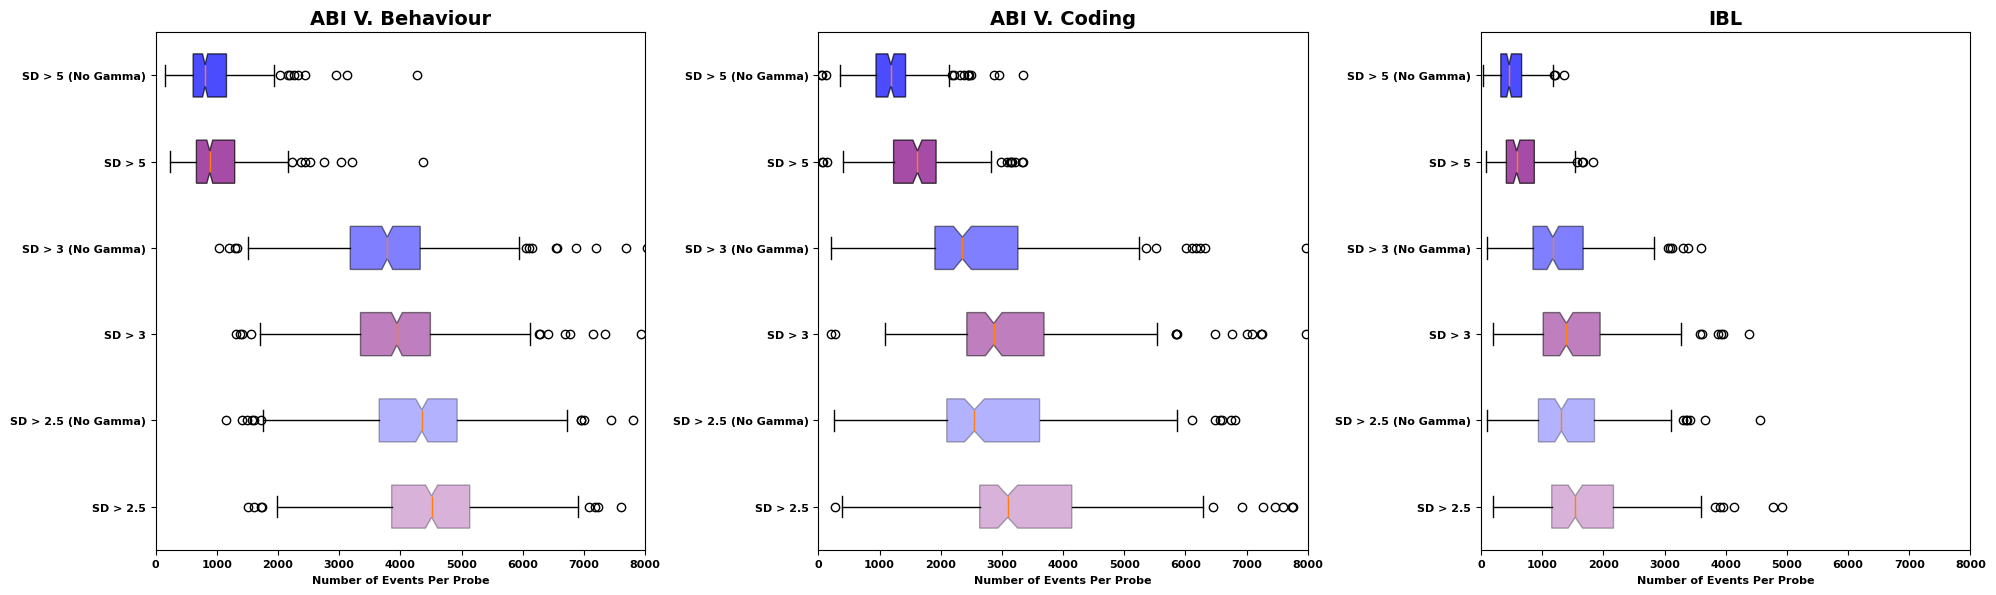

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text

# Define the columns and corresponding colors and opacities
columns = ['minpeak2p5_nomove', 'minpeak2p5_nomove_nogamma', 'minpeak3_nomove', 'minpeak3_nomove_nogamma', 'minpeak5_nomove', 'minpeak5_nomove_nogamma']
labels = ['SD > 2.5', 'SD > 2.5 (No Gamma)', 'SD > 3', 'SD > 3 (No Gamma)', 'SD > 5', 'SD > 5 (No Gamma)']
colors = ['purple', 'blue'] * 3  # Repeat the color list for each pair of columns
opacities = [0.3, 0.3, 0.5, 0.5, 0.7, 0.7] # Repeat the opacity list for each pair of columns

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, df in enumerate([abi_visbehave_probe_level_results,abi_viscoding_probe_level_results, ibl_probe_level_results]):
    data = []
    for column in columns:
        data.append(df[column].dropna())
    bp = axs[i].boxplot(data, patch_artist=True, notch=True, vert=0)
    axs[i].set_yticklabels(labels)
    axs[i].set_xlabel('Number of Events Per Probe', fontsize=8, fontweight='bold')
    axs[i].set_xlim([0, 8000])

    # Set colors and opacities for each box
    for patch, color, opacity in zip(bp['boxes'], colors, opacities):
        patch.set_facecolor(color)
        patch.set_alpha(opacity)

axs[0].set_title('ABI V. Behaviour', fontsize=14, fontweight='bold')
axs[1].set_title('ABI V. Coding', fontsize=14, fontweight='bold')
axs[2].set_title('IBL', fontsize=14, fontweight='bold')

plt.tight_layout()

# Save the figure before showing it
plt.savefig("/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure1_f.svg", format='svg')

plt.show()

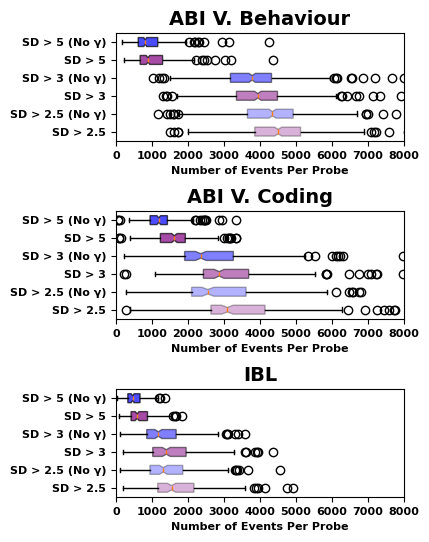

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams['font.size'] = 8
plt.rcParams['font.weight'] = 'bold'

# Define the columns and corresponding colors and opacities
columns = ['minpeak2p5_nomove', 'minpeak2p5_nomove_nogamma', 'minpeak3_nomove', 'minpeak3_nomove_nogamma', 'minpeak5_nomove', 'minpeak5_nomove_nogamma']
labels = ['SD > 2.5', 'SD > 2.5 (No γ)', 'SD > 3', 'SD > 3 (No γ)', 'SD > 5', 'SD > 5 (No γ)']
colors = ['purple', 'blue'] * 3  # Repeat the color list for each pair of columns
opacities = [0.3, 0.3, 0.5, 0.5, 0.7, 0.7] # Repeat the opacity list for each pair of columns

# Convert figure size from mm to inches (1 inch = 25.4 mm)
fig_width_mm = 110
fig_height_mm = 138.75
fig_width_in = fig_width_mm / 25.4
fig_height_in = fig_height_mm / 25.4

fig, axs = plt.subplots(3, 1, figsize=(fig_width_in, fig_height_in))

for i, df in enumerate([abi_visbehave_probe_level_results,abi_viscoding_probe_level_results, ibl_probe_level_results]):
    data = []
    for column in columns:
        data.append(df[column].dropna())
    bp = axs[i].boxplot(data, patch_artist=True, notch=True, vert=0)
    axs[i].set_yticklabels(labels)
    axs[i].set_xlabel('Number of Events Per Probe', fontsize=8, fontweight='bold')
    axs[i].set_xlim([0, 8000])

    # Set colors and opacities for each box
    for patch, color, opacity in zip(bp['boxes'], colors, opacities):
        patch.set_facecolor(color)
        patch.set_alpha(opacity)

axs[0].set_title('ABI V. Behaviour', fontsize=14, fontweight='bold')
axs[1].set_title('ABI V. Coding', fontsize=14, fontweight='bold')
axs[2].set_title('IBL', fontsize=14, fontweight='bold')

plt.tight_layout()

# Save the figure before showing it
plt.savefig("/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure1_f_smol_threeplots.svg", format='svg')

plt.show()

In [32]:
import os

missing_gamma_file = []
missing_no_gamma_file = []

for sessionfolder in os.listdir(ibl_ripples_path):
    if '.csv' in sessionfolder:
            continue
    folder_path = os.path.join(ibl_ripples_path, sessionfolder)
    folderfiles = os.listdir(folder_path)
    
    session_id = sessionfolder.split('_')[-1]
    
    if not any('global_swrs_no_movement_no_gamma.csv' in file for file in folderfiles):
        missing_no_gamma_file.append(session_id)
        
    if not any('global_swrs_no_movement.csv' in file for file in folderfiles):
        missing_gamma_file.append(session_id)

print("Sessions missing 'global_swrs_no_movement_no_gamma.csv':", missing_no_gamma_file)
print("Sessions missing 'global_swrs_no_movement.csv':", missing_gamma_file)

Sessions missing 'global_swrs_no_movement_no_gamma.csv': ['caa5dddc-9290-4e27-9f5e-575ba3598614']
Sessions missing 'global_swrs_no_movement.csv': ['caa5dddc-9290-4e27-9f5e-575ba3598614']


In [33]:
import pandas as pd

# Filter os.listdir(ibl_ripples_path) for strings that contain the substrings in missing_no_gamma_file
problematic_sessionfolders = [folder for folder in os.listdir(ibl_ripples_path) if any(sub in folder for sub in missing_no_gamma_file)]

for sessionfolder in problematic_sessionfolders:
    print(f"Processing session folder: {sessionfolder}")
    folder_path = os.path.join(ibl_ripples_path, sessionfolder)
    folderfiles = os.listdir(folder_path)
    
    # Load each csv file containing the substring 'karlsson' in the filename
    probe_file = 0
    for file in folderfiles:
        if 'karlsson' in file:
            probe_file = probe_file+1
            df = pd.read_csv(os.path.join(folder_path, file), compression='gzip')
            print(f"Shape of {file} for probe_file {probe_file}: {df.shape}")
            print(f"Max zscore is {np.max(df['max_zscore'])} number greater than >2.5 is {np.sum(df['max_zscore']>2.5)}, >3 is {np.sum(df['max_zscore']>3)}, >5 is {np.sum(df['max_zscore']>5)}.")
            # Filter by Overlaps_with_movement == False
            df_no_movement = df[df['Overlaps_with_movement'] == False]
            print(f"Shape of {file} for probe_file {probe_file} after filtering by Overlaps_with_movement == False: {df_no_movement.shape}")
            print(f"Max zscore is {np.max(df_no_movement['max_zscore'])} number greater than >2.5 is {np.sum(df_no_movement['max_zscore']>2.5)}, >3 is {np.sum(df_no_movement['max_zscore']>3)}, >5 is {np.sum(df['max_zscore']>5)}.")

            # Further filter by Overlapswith_gamma == False
            df_no_movement_no_gamma = df_no_movement[df_no_movement['Overlaps_with_gamma'] == False]
            print(f"Shape of {file} for probe_file {probe_file} after further filtering by Overlapswith_gamma == False: {df_no_movement_no_gamma.shape}")
            print(f"Max zscore is {np.max(df_no_movement_no_gamma['max_zscore'])} number greater than >2.5 is {np.sum(df_no_movement_no_gamma['max_zscore']>2.5)}, >3 is {np.sum(df_no_movement_no_gamma['max_zscore']>3)}, >5 is {np.sum(df_no_movement_no_gamma['max_zscore']>5)}.")


Processing session folder: swrs_session_caa5dddc-9290-4e27-9f5e-575ba3598614
Shape of probe_d0046384-16ea-4f69-bae9-165e8d0aeacf_channel_channelsrawInd_288_karlsson_detector_events.csv for probe_file 1: (20, 11)
Max zscore is 5.764444839887925 number greater than >2.5 is 20, >3 is 10, >5 is 1.
Shape of probe_d0046384-16ea-4f69-bae9-165e8d0aeacf_channel_channelsrawInd_288_karlsson_detector_events.csv for probe_file 1 after filtering by Overlaps_with_movement == False: (17, 11)
Max zscore is 5.764444839887925 number greater than >2.5 is 17, >3 is 10, >5 is 1.
Shape of probe_d0046384-16ea-4f69-bae9-165e8d0aeacf_channel_channelsrawInd_288_karlsson_detector_events.csv for probe_file 1 after further filtering by Overlapswith_gamma == False: (16, 11)
Max zscore is 5.764444839887925 number greater than >2.5 is 16, >3 is 10, >5 is 1.
Shape of probe_4836a465-c691-4852-a0b1-dcd2b1ce38a1_channel_channelsrawInd_215_karlsson_detector_events.csv for probe_file 2: (28, 11)
Max zscore is 4.549784345773

In [34]:
df

event_number   start_time     end_time  duration  mean_zscore  \
0              1    84.723301    84.795967  0.072667     1.263991   
1              4   301.980719   302.067386  0.086667     1.295105   
2              5   324.168728   324.220728  0.052000     1.789550   
3              6   325.110728   325.164728  0.054000     1.548111   
4              7   328.484063   328.534063  0.050000     1.552777   
5              8   464.413450   464.476116  0.062667     1.857545   
6              9   482.384790   482.506123  0.121333     1.349727   
7             10   784.058908   784.151575  0.092667     1.263179   
8             11   841.753598   841.854931  0.101333     1.134346   
9             12   972.824316   972.906982  0.082667     1.478611   
10            13   975.217650   975.287650  0.070000     1.691978   
11            14  1024.726336  1024.833003  0.106667     1.548599   
12            15  1121.655707  1121.727041  0.071333     1.232675   
13            16  1124.371042  1124.434375  0.063333     1.291760   
14            17  1127.722377  1127.783710  0.061333     1.174916   
15            18  1171.133727  1171.208394  0.074667     1.176040   
16            19  1272.769100  1272.837100  0.068000     1.406584   
17            20  1347.815796  1347.916463  0.100667     1.516635   
18            21  1408.684487  1408.752487  0.068000     1.583304   
19            22  1436.994498  1437.103831  0.109333     1.734537   
20            23  1439.196499  1439.258499  0.062000     1.174099   
21            24  1595.350560  1595.425227  0.074667     0.993282   
22            25  1623.665238  1623.707238  0.042000     1.903129   
23            26  1634.129908  1634.249909  0.120000     1.357697   
24            27  1634.293909  1634.339909  0.046000     1.737757   
25            28  1642.231912  1642.376578  0.144667     1.140243   
26            29  1660.462585  1660.551919  0.089333     1.278375   
27            30  1785.233301  1785.282634  0.049333     1.612647   

    median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
0        1.344055    2.324298    0.006972    84.760634                False   
1        0.595410    3.897975    0.014943   301.999386                False   
2        1.832596    3.414143    0.004660   324.191395                False   
3        1.366134    3.386740    0.000801   325.140728                False   
4        1.730423    2.828181    0.003372   328.503396                False   
5        2.126588    3.357263    0.020777   464.444783                False   
6        1.093008    3.226788    0.005081   482.424790                False   
7        1.021782    3.116740    0.009732   784.115575                False   
8        0.323708    3.549302    0.002077   841.816264                False   
9        1.327036    3.232547    0.002688   972.851649                False   
10       1.947290    2.854299    0.019558   975.236983                False   
11       1.598994    2.962461    0.003739  1024.763003                False   
12       0.822848    3.071056    0.006727  1121.689041                False   
13       0.685867    3.788557    0.004602  1124.391042                False   
14       0.921027    2.637770    0.007953  1127.743043                False   
15       0.614076    3.745849    0.002142  1171.160394                False   
16       0.850946    3.664994    0.006292  1272.811767                False   
17       1.213546    3.419644    0.016104  1347.881130                False   
18       1.277308    3.630737    0.014293  1408.721820                False   
19       1.586254    3.692042    0.004352  1437.045164                False   
20       0.817477    2.518793    0.008779  1439.223165                False   
21       0.718228    2.339267    0.003676  1595.387227                False   
22       1.949710    3.729007    0.019907  1623.689238                False   
23       1.048769    3.118136    0.010752  1634.220575                False   
24       1.206647    4.5497

## Ripples by theta and Wheel Speed

In [35]:
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:

theta_filter_path = '/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz'
theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter['arr_0']

In [38]:
#
speeds = []
theta_powers = {'peakwindow_med':[],'peakwindow_mean':[],
                'eventwindow_med':[],'eventwindow_mean':[]}
theta_compute_halfwindow = 0.125
failed_sesh = []




In [39]:
"""
for sessionfolder in os.listdir(ibl_ripples_path)[0:1]:
    try:
        if '.csv' in sessionfolder:
            continue 
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        try:
            global_ripples_filename = [file for file in folderfiles if 'global_swrs' in file][0]
        except:
            continue
        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression='gzip')
        session_id = sessionfolder.split('_')[-1]
        
        # getting speeds
        wheel = one.load_object(session_id, 'wheel', collection='alf')
        pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
        delta_t = 1/np.array([t[i]-t[i-1] for i in range(1,t.shape[0]) ]).mean()
        wh_vel, wh_accel = wh.velocity_filtered(pos, delta_t)
        
        average_speeds = []
        for _, row in global_ripples_df.iterrows():
            start_time = row['start_time']
            end_time = row['end_time']
            mask = (t >= start_time) & (t <= end_time)
            average_speed = np.abs(wh_vel[mask]).mean()
            average_speeds.append(average_speed)
        
        global_ripples_df['average_speed'] = average_speeds
        speeds.extend(average_speeds)
        
        lfp_session_path = f"{ibl_lfp_path}/lfp_session_{session_id}"
        lfp_files = os.listdir(lfp_session_path)
        for file in folderfiles:
            # we load lfp data for the karlsson files, then we compute theta power (zscored) and take that values
            # in a window around the peak of the swr
            if not 'karlsson' in file:
                continue
            
            # load the data
            events_df = pd.read_csv(os.path.join(folder_path,file), compression ='gzip')
            events_df = events_df[(events_df.Overlaps_with_gamma==True) & (events_df.Overlaps_with_movement==True)]
            probe_id = re.search(r'probe_(.*?)_', file).group(1)
            channel_indx = re.search(r'channelsrawInd_(.*?)_', file).group(1)
            lfp_data = [file for file in lfp_files if f"channelsrawInd_{channel_indx}" in file and probe_id in file and "ca1_peakripplepower.npz" in file]
            lfp_data = np.load(os.path.join(lfp_session_path,lfp_data[0]))
            lfp_data = lfp_data['lfp_ca1']
            lfp_times = [file for file in lfp_files if f"channelsrawInd_{channel_indx}" in file and probe_id in file and "time_index_1500hz.npz" in file]
            lfp_times = np.load(os.path.join(lfp_session_path,lfp_times[0]))
            lfp_times = lfp_times['lfp_time_index']
            
            # compute theta power
            theta_pow_zscore = np.convolve(lfp_data, theta_filter, mode='same')
            theta_pow_zscore = scipy.stats.zscore(np.abs(signal.hilbert(theta_pow_zscore))**2)
            
            for _, event in events_df.iterrows():
                # Compute median and mean for peak window
                peak_start = event['Peak_time'] - theta_compute_halfwindow
                peak_end = event['Peak_time'] + theta_compute_halfwindow
                peak_window_data = theta_pow_zscore[(lfp_times >= peak_start) & (lfp_times <= peak_end)]
                theta_powers['peakwindow_med'].append(np.median(peak_window_data))
                theta_powers['peakwindow_mean'].append(np.mean(peak_window_data))

                # Compute median and mean for event window
                event_window_data = theta_pow_zscore[(lfp_times >= event['start_time']) & (lfp_times <= event['end_time'])]
                theta_powers['eventwindow_med'].append(np.median(event_window_data))
                theta_powers['eventwindow_mean'].append(np.mean(event_window_data))
    except:
        failed_sesh.append(sessionfolder)
        continue
"""




'\nfor sessionfolder in os.listdir(ibl_ripples_path)[0:1]:\n    try:\n        if \'.csv\' in sessionfolder:\n            continue \n        folder_path = os.path.join(ibl_ripples_path, sessionfolder)\n        folderfiles = os.listdir(folder_path)\n        try:\n            global_ripples_filename = [file for file in folderfiles if \'global_swrs\' in file][0]\n        except:\n            continue\n        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression=\'gzip\')\n        session_id = sessionfolder.split(\'_\')[-1]\n        \n        # getting speeds\n        wheel = one.load_object(session_id, \'wheel\', collection=\'alf\')\n        pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)\n        delta_t = 1/np.array([t[i]-t[i-1] for i in range(1,t.shape[0]) ]).mean()\n        wh_vel, wh_accel = wh.velocity_filtered(pos, delta_t)\n        \n        average_speeds = []\n        for _, row in global_ripples_df.iterrows():\n      

In [40]:
# saved to avoid having to regenerate it, only used in debugging, will delete in and this seciton later

# Save the dictionary
#with open('theta_powers_ibl.pkl', 'wb') as f:
#    pickle.dump(theta_powers, f)

# Save the numpy array
#np.save('speeds_ibl.npy', speeds)

In [41]:
with open('/home/acampbell/theta_powers_ibl.pkl', 'rb') as f:
    theta_powers = pickle.load(f)

# Load the numpy array
speeds = np.load('/home/acampbell/speeds_ibl.npy')


In [42]:
len(speeds)

217202

In [43]:
print(theta_powers['peakwindow_med'][0:5])
print(theta_powers['peakwindow_mean'][0:5])
print(theta_powers['eventwindow_med'][0:5])
print(theta_powers['eventwindow_mean'][0:5])

[0.23518028384686465, 0.5732154331651866, 1.5985260122850942, -0.16323959665790522, 4.617420330287844]
[0.15589910970860368, 0.5155955743665097, 1.5417713828960693, -0.0970403154623254, 3.7960752236111097]
[0.478323196291428, 0.9563774688016099, 2.15248655129329, -0.1321801128277746, 5.537797158281668]
[0.4205544305048518, 0.8571026575356367, 2.025033684338973, -0.13094182867530463, 5.250610796971575]


In [44]:
import pandas as pd

columns = ['peakwindow_med', 'peakwindow_mean', 'eventwindow_med', 'eventwindow_mean']
nan_indices = []
cleaned_theta_data = {}

for col in columns:
    data = pd.Series(theta_powers[col])
    nan_index = data.index[data.isna()].tolist()
    nan_indices.append(set(nan_index))
    cleaned_theta_data[col] = data.dropna()

# Check if all NaN indices are the same
if len(set.intersection(*nan_indices)) == len(nan_indices[0]):
    print("All NaN indices are the same.")
else:
    print("NaN indices are not the same.")

# Print min and max values of cleaned data
for col, data in cleaned_theta_data.items():
    print(f"For {col}, Min: {data.min()}, Max: {data.max()}")

All NaN indices are the same.
For peakwindow_med, Min: -1.1418453235290944, Max: 89.99995746102553
For peakwindow_mean, Min: -1.1112523147827573, Max: 85.86173226022319
For eventwindow_med, Min: -1.1907076698537382, Max: 128.42608768556204
For eventwindow_mean, Min: -1.1894699340446324, Max: 126.86507692637028


In [45]:
cleaned_theta_data.keys()

dict_keys(['peakwindow_med', 'peakwindow_mean', 'eventwindow_med', 'eventwindow_mean'])

In [46]:
figure_six_path = "/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure6/"

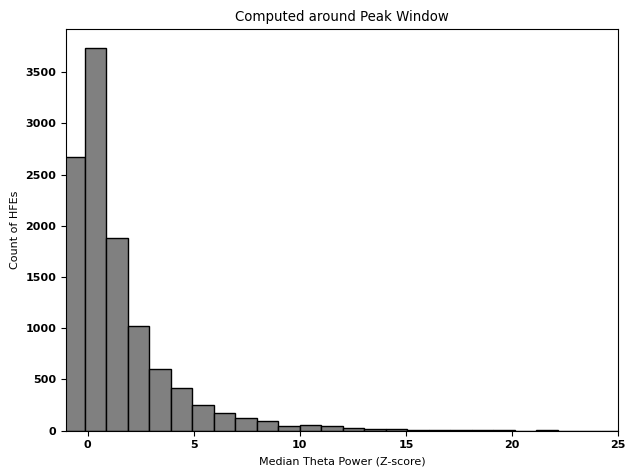

In [47]:
plt.hist(cleaned_theta_data['peakwindow_med'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Median Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed around Peak Window')
plt.tight_layout()
plt.show()

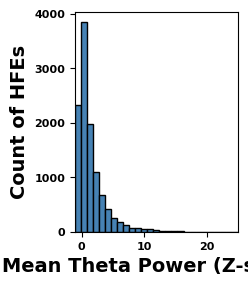

In [48]:
# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams['pdf.use14corefonts'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

plt.hist(cleaned_theta_data['peakwindow_mean'], bins=90, edgecolor='black', facecolor='steelblue')
plt.xlim(-1, 25)
plt.xlabel('Mean Theta Power (Z-score)', fontsize=14, weight='bold')
plt.ylabel('Count of HFEs', fontsize=14, weight='bold')

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))

#plt.title('Computed around Peak Window')
plt.tight_layout()
plt.savefig(f"{figure_six_path}_ibl_theta_six_b.svg", format='svg')
plt.show()

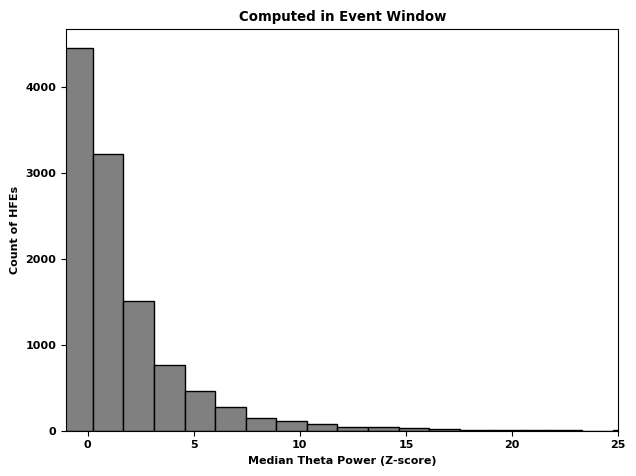

In [49]:
plt.hist(cleaned_theta_data['eventwindow_med'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Median Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed in Event Window')
plt.tight_layout()
plt.show()

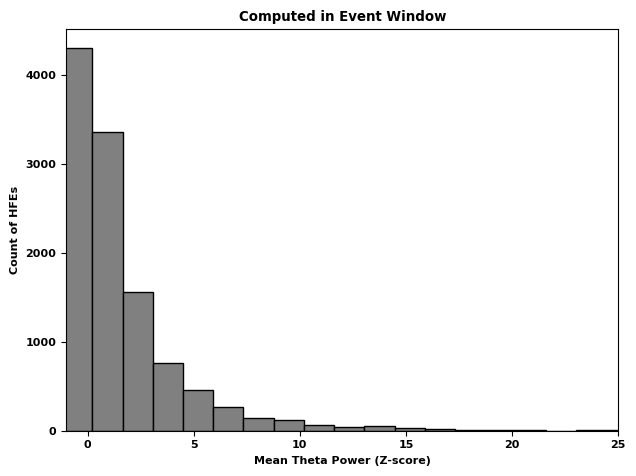

In [50]:
plt.hist(cleaned_theta_data['eventwindow_mean'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Mean Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed in Event Window')
plt.tight_layout()
plt.show()

In [51]:
speed_cleaned = speeds[~np.isnan(speeds)]

In [52]:
speed_cleaned.max()

17.057541264876384

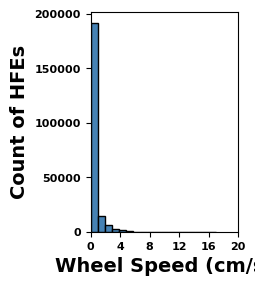

In [53]:
# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams['pdf.use14corefonts'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

plt.hist(speeds, bins=18, edgecolor='black', facecolor='steelblue')
plt.xlim(0, 20)
plt.xlabel('Wheel Speed (cm/s)', fontsize=14, weight='bold')
plt.ylabel('Count of HFEs', fontsize=14, weight='bold')

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))

plt.tight_layout()
plt.savefig(f"{figure_six_path}_ibl_wheelspeed_six_d.svg", format='svg')
plt.show()

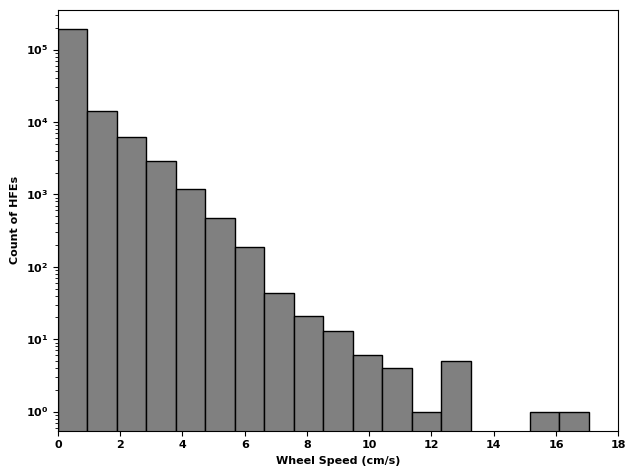

In [54]:
plt.hist(speeds, bins=18, edgecolor='black', facecolor='grey', log=True)
plt.xlim(0, 18)
plt.xlabel('Wheel Speed (cm/s)')
plt.ylabel('Count of HFEs')
plt.yscale('log', base=10)
plt.tight_layout()
plt.show()

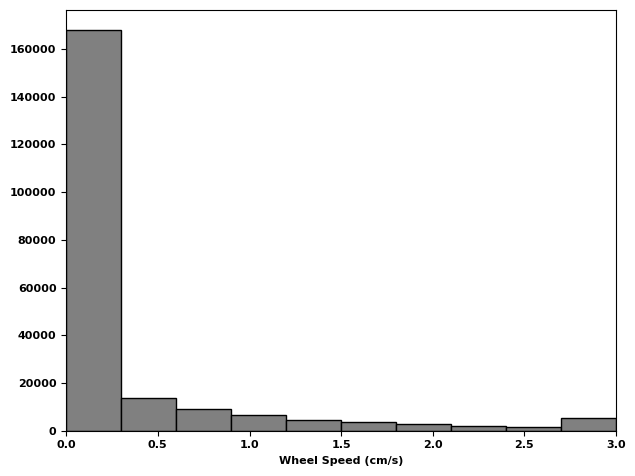

In [55]:
# Matplotlib
plt.hist(np.minimum(speeds, 3), bins=10, edgecolor='black', facecolor='grey')
plt.xlim(0, 3)
plt.xlabel('Wheel Speed (cm/s)')
plt.tight_layout()
plt.show()

## Ripple Distributions

In [57]:
path = '/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024/eventspersession_df.csv'
df = pd.read_csv(path, compression = 'gzip')
df.columns

Index(['session_id', 'probe_id', 'ripple_number'], dtype='object')

In [58]:
# getting 
directories = os.listdir(ibl_ripples_path)

processed_sesh_ids = [dir.replace('swrs_session_', '') for dir in directories if 'swrs_session_' in dir]

print(processed_sesh_ids)

['0cc486c3-8c7b-494d-aa04-b70e2690bcba', '746d1902-fa59-4cab-b0aa-013be36060d5', '6a601cc5-7b79-4c75-b0e8-552246532f82', 'edd22318-216c-44ff-bc24-49ce8be78374', '6c6983ef-7383-4989-9183-32b1a300d17a', 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9', '5386aba9-9b97-4557-abcd-abc2da66b863', 'c6db3304-c906-400c-aa0f-45dd3945b2ea', 'a2701b93-d8e1-47e9-a819-f1063046f3e7', '3e6a97d3-3991-49e2-b346-6948cb4580fb', '8928f98a-b411-497e-aa4b-aa752434686d', '3638d102-e8b6-4230-8742-e548cd87a949', 'fcd49e34-f07b-441c-b2ac-cb8c462ec5ac', '0c828385-6dd6-4842-a702-c5075f5f5e81', 'b39752db-abdb-47ab-ae78-e8608bbf50ed', '1a507308-c63a-4e02-8f32-3239a07dc578', '572a95d1-39ca-42e1-8424-5c9ffcb2df87', '15b69921-d471-4ded-8814-2adad954bcd8', '02fbb6da-3034-47d6-a61b-7d06c796a830', '4b00df29-3769-43be-bb40-128b1cba6d35', 'd9f0c293-df4c-410a-846d-842e47c6b502', '9b528ad0-4599-4a55-9148-96cc1d93fb24', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '7691eeb3-715b-4571-8fda-6bb57aab8253', 'ebe090af-5922-4fcd-8fc6-17b8ba7bad6d',

In [59]:
all_swrs_df = pd.DataFrame()
global_swr_failed_session = []
for sessionfolder in os.listdir(ibl_ripples_path):
    try:
        if 'global_swrs_no_movement_no_gamma.csv' in sessionfolder:
            continue 
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        try:
            global_ripples_filename = [file for file in folderfiles if 'global_swrs' in file][0]
            
        except:
            continue
        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression='gzip')
        global_ripples_df['duration'] = global_ripples_df['end_time'] - global_ripples_df['start_time']
        global_ripples_df['session_id'] = sessionfolder.replace('swrs_session_', '')
        all_swrs_df = pd.concat([all_swrs_df, global_ripples_df])
    except:
        global_swr_failed_session.append(sessionfolder)

In [60]:
all_swrs_df.columns

Index(['start_time', 'end_time', 'probes_event_is_on', 'events_row_index',
       'global_peak_time', 'global_max_zscore', 'peak_probe', 'duration',
       'session_id'],
      dtype='object')

sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm          0.000008  2096.898753 -6.476706e+06     inf      0.018477   
halfnorm         0.000098  4257.184007 -5.816600e+06     inf      0.073348   
norm             0.000176  7665.945197 -5.659951e+06     inf      0.131960   

             ks_pvalue  
lognorm   8.280022e-80  
halfnorm  0.000000e+00  
norm      0.000000e+00

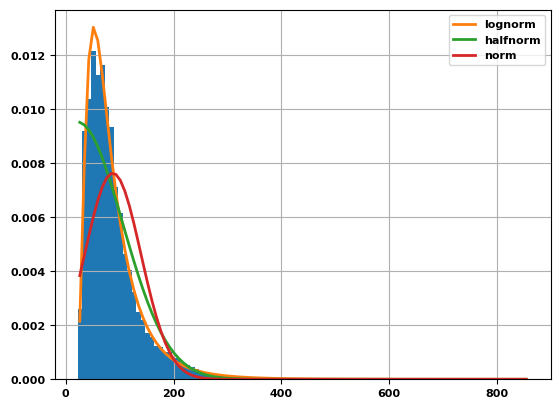

In [61]:
f_distributions_dur = Fitter(all_swrs_df['duration']*1000,
           distributions=['norm',
                          'lognorm',
                         'halfnorm'])
f_distributions_dur.fit()
f_distributions_dur.summary()

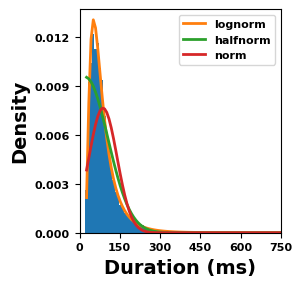

In [62]:
# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams['pdf.use14corefonts'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

# Plot the histogram
f_distributions_dur.hist()

# Plot the PDF
f_distributions_dur.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)
ax.set_xlim(0, 750)

# Set the title and axis labels
ax.set_xlabel('Duration (ms)', fontsize=14, weight='bold')
ax.set_ylabel('Density', fontsize=14, weight='bold')

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))


plt.savefig(f"{figure_six_path}_ibl_durationdist_six_f.svg", format='svg')
# Display the plot
plt.show()

sumsquare_error           aic           bic  kl_div  ks_statistic  \
lognorm          0.004150   1858.383665 -4.813289e+06     inf      0.044243   
halfnorm         0.060779   7655.804380 -4.094847e+06     inf      0.225892   
norm             0.103023  11780.716227 -3.953592e+06     inf      0.221353   

          ks_pvalue  
lognorm         0.0  
halfnorm        0.0  
norm            0.0

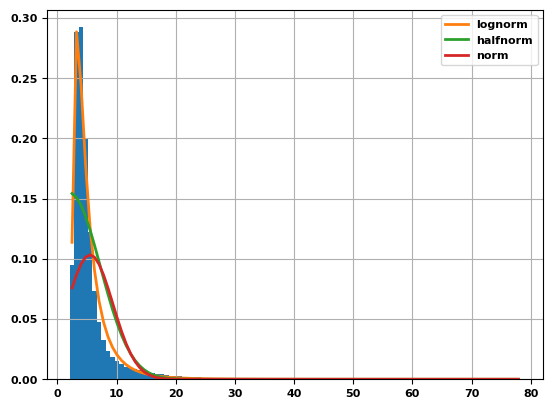

In [63]:
f_distributions_pow = Fitter(all_swrs_df['global_max_zscore'],
           distributions=['norm',
                          'lognorm',
                         'halfnorm'])
f_distributions_pow.fit()
f_distributions_pow.summary()

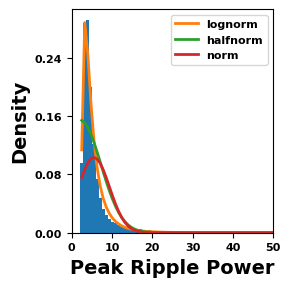

In [64]:
# Ensure text is exported as text objects
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams['pdf.use14corefonts'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

# Plot the histogram
f_distributions_pow.hist()

# Plot the PDF
f_distributions_pow.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)

# Set x-axis limits
#ax.set_xlim([0, 70])  # replace with your desired limits


# Set the title and axis labels
ax.set_xlabel('Peak Ripple Power', fontsize=14, weight='bold')
ax.set_ylabel('Density', fontsize=14, weight='bold')

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.set_xlim([0, 50])
plt.savefig(f"{figure_six_path}_ibl_powerdist_six_h.svg", format='svg')
# Display the plot
plt.show()

## Artifact Plots

In [65]:
# lfp and filter filepath

# Pick a session at random...
#ibl_lfp_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024_lfp_data/lfp_session_61e11a11-ab65-48fb-ae08-3cb80662e5d6'
#ibl_swr_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024/swrs_session_61e11a11-ab65-48fb-ae08-3cb80662e5d6'
ibl_lfp_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024_lfp_data/lfp_session_dd4da095-4a99-4bf3-9727-f735077dba66'
ibl_swr_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024/swrs_session_dd4da095-4a99-4bf3-9727-f735077dba66'



gamma_filter_path = '/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/frank2008_gamma_1500hz_bandpass_filter.npz'
# The path to the theta filter
theta_filter_path = '/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz'
# The ripple band threshold

# loading filters (craetes artifacts in first and last ~ 3.5 seconds of recordings, remember to clip these off)
gamma_filter = np.load(gamma_filter_path)
gamma_filter = gamma_filter['arr_0']

theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter['arr_0']

In [66]:
os.listdir(ibl_lfp_path)

['probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_lfp_ca1_peakripplepower.npz',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_168_lfp_control_channel.npz',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_375_lfp_control_channel.npz',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_lfp_time_index_1500hz.npz']

In [67]:
os.listdir(ibl_swr_path)

['probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_gamma_band_events.csv',
 'session_dd4da095-4a99-4bf3-9727-f735077dba66_putative_global_swrs_no_movement_no_gamma.csv',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_168_movement_artifacts.csv',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_375_movement_artifacts.csv',
 'session_dd4da095-4a99-4bf3-9727-f735077dba66_putative_global_swrs_no_movement.csv',
 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_karlsson_detector_events.csv']

In [68]:
# load the swrs data and the artifacts
figure_four_path = '/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure4'
figure_five_path = '/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure5'
"""
probelevelswrs_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_259_karlsson_detector_events.csv'
gamma_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_259_gamma_band_events.csv'
first_movement_artifact_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_180_movement_artifacts.csv'
second_movement_artifact_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_336_movement_artifacts.csv'
"""

gamma_file =  'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_gamma_band_events.csv'
first_movement_artifact_file =  'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_168_movement_artifacts.csv'
second_movement_artifact_file = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_375_movement_artifacts.csv'
probelevelswrs_file =   'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_karlsson_detector_events.csv'

# load the lfp events dfs
swr_df = pd.read_csv(os.path.join(ibl_swr_path,probelevelswrs_file),compression='gzip')
swr_df = swr_df[swr_df.max_zscore>=3]
gamma_events_df = pd.read_csv(os.path.join(ibl_swr_path,gamma_file),compression='gzip')
first_moveartifacts_df = pd.read_csv(os.path.join(ibl_swr_path,first_movement_artifact_file),compression='gzip')
second_moveartifacts_df = pd.read_csv(os.path.join(ibl_swr_path,second_movement_artifact_file),compression='gzip')

# load the lfp data
"""
ca1_chan_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_259_lfp_ca1_peakripplepower.npz'
first_control_chan_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_180_lfp_control_channel.npz'
second_control_chan_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_336_lfp_control_channel.npz'
time_index_file = 'probe_31f3e083-a324-4b88-b0a4-7788ec37b191_channel_channelsrawInd_259_lfp_time_index_1500hz.npz'
"""
ca1_chan_file = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_lfp_ca1_peakripplepower.npz'
first_control_chan_file =  'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_168_lfp_control_channel.npz'
second_control_chan_file = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_375_lfp_control_channel.npz'
time_index_file = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_lfp_time_index_1500hz.npz'

ca1_lfp_data = np.load(os.path.join(ibl_lfp_path,ca1_chan_file))
ca1_lfp_data = ca1_lfp_data['lfp_ca1']
first_control_lfp_data = np.load(os.path.join(ibl_lfp_path,first_control_chan_file))
first_control_lfp_data = first_control_lfp_data['lfp_control_channel']
second_control_lfp_data = np.load(os.path.join(ibl_lfp_path,second_control_chan_file))
second_control_lfp_data = second_control_lfp_data['lfp_control_channel']
time_arr = np.load(os.path.join(ibl_lfp_path,time_index_file))
time_arr = time_arr['lfp_time_index']

# Compute gamma and ripple powers
ripple_band_ca1  = np.squeeze(filter_ripple_band(ca1_lfp_data[:,None]))
gamma_band_ca1 = np.convolve(ca1_lfp_data, gamma_filter, mode='same')
ripple_band_first_control = np.squeeze(filter_ripple_band(first_control_lfp_data[:,None]))
ripple_band_second_control = np.squeeze(filter_ripple_band(second_control_lfp_data[:,None]))


In [69]:
swr_df[(swr_df['Overlaps_with_movement']==False) & (swr_df['Overlaps_with_gamma']==False)].sort_values('max_zscore', ascending=False).head(10)

event_number   start_time     end_time  duration  mean_zscore  \
93             96   710.893555   711.028222  0.134667     5.772133   
311           323  1728.815207  1728.936540  0.121333     8.118224   
69             72   536.015501   536.072167  0.056667     9.419180   
317           330  1773.157221  1773.286554  0.129333     3.767396   
319           332  1776.327222  1776.417222  0.090000     7.249672   
354           369  1849.233244  1849.320578  0.087333     7.178831   
190           199  1267.951729  1268.079729  0.128000     4.421469   
170           178  1132.081687  1132.216354  0.134667     7.303685   
340           353  1814.561234  1814.653900  0.092667     6.617774   
298           309  1671.085189  1671.241855  0.156667     3.961716   

     median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
93        1.360401   30.025266    0.030431   710.967555                False   
311       4.492035   25.731307    0.012713  1728.857873                False   
69        6.621874   24.554449    0.028908   536.042167                False   
317       0.560085   23.355002    0.011441  1773.237887                False   
319       4.125804   22.396385    0.021242  1776.355888                False   
354       3.008206   22.039039    0.008441  1849.266578                False   
190       1.320305   21.355201    0.017884  1268.045063                False   
170       6.235302   21.275243    0.009555  1132.141687                False   
340       1.754542   21.069848    0.013826  1814.603900                False   
298       1.322567   20.672179    0.001173  1671.171855                False   

     Overlaps_with_movement  
93                    False  
311                   False  
69                    False  
317                   False  
319                   False  
354                   False  
190                   False  
170                   False  
340                   False  
298                   False

In [70]:
first_artifact_df = pd.read_csv(os.path.join(ibl_swr_path, first_movement_artifact_file), compression = 'gzip') 
second_artifact_df = pd.read_csv(os.path.join(ibl_swr_path, second_movement_artifact_file), compression = 'gzip') 

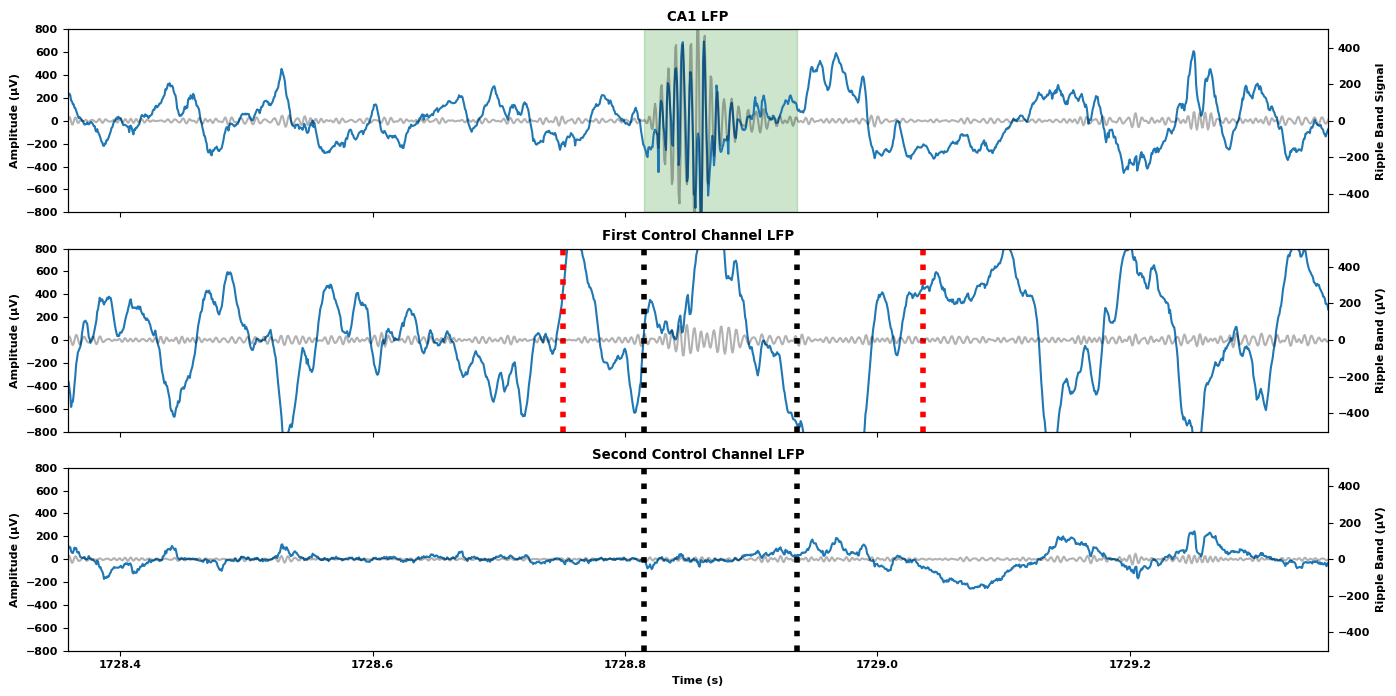

In [71]:
# Change the event number to pick a different ripple
# old version of figure we don't save it anymore
rip_id = 323
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]*1e6
ripple_band_ca1_slice = ripple_band_ca1[mask]*1e6
linethickness = 4
riplim = 500
lfplim = 800

# Calculate global min and max for LFP data
lfp_min = min(np.min(ca1_lfp_data_slice), np.min(first_control_lfp_data[mask]), np.min(second_control_lfp_data[mask]))
lfp_max = max(np.max(ca1_lfp_data_slice), np.max(first_control_lfp_data[mask]), np.max(second_control_lfp_data[mask]))

# Calculate global min and max for ripple band data
ripple_min = min(np.min(ripple_band_ca1_slice), np.min(ripple_band_first_control[mask]), np.min(ripple_band_second_control[mask]))
ripple_max = max(np.max(ripple_band_ca1_slice), np.max(ripple_band_first_control[mask]), np.max(ripple_band_second_control[mask]))

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('CA1 LFP')
#plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.gca().set_xticklabels([])
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        # Check if the event overlaps with gamma or movement
        if event.Overlaps_with_gamma or event.Overlaps_with_movement:
            plt.axvspan(event.start_time, event.end_time, color='red', alpha=0.2)
        else:
            plt.axvspan(event.start_time, event.end_time, color='green', alpha=0.2)

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax2.set_ylim(-riplim, riplim)
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))


plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, first_control_lfp_data[mask]*1e6)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('First Control Channel LFP')
#plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.gca().set_xticklabels([])
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)
        
        
# Iterate over all events in first_artifact_df
for idx, row in first_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)

# Add the ripple band for the first control channel
ax4 = plt.twinx()  # Create a second y-axis
ax4.plot(time_arr_slice, ripple_band_first_control[mask]*1e6, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax4.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax4.set_ylabel('Ripple Band (µV)')  # Set label for the second y-axis
ax4.set_ylim(-riplim, riplim)
#ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, second_control_lfp_data[mask]*1e6)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('Second Control Channel LFP') 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)

# Iterate over all events in second_artifact_df
for idx, row in second_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)
        
# Add the ripple band for the second control channel
ax6 = plt.twinx()  # Create a second y-axis
ax6.plot(time_arr_slice, ripple_band_second_control[mask]*1e6, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax6.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax6.set_ylabel('Ripple Band (µV)')  # Set label for the second y-axis
ax6.set_ylim(-riplim, riplim)
#ax6.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

#plt.savefig(f"{figure_four_path}/four_a.svg", format='svg') # old figure we don't save it anymore
plt.tight_layout()
plt.show()

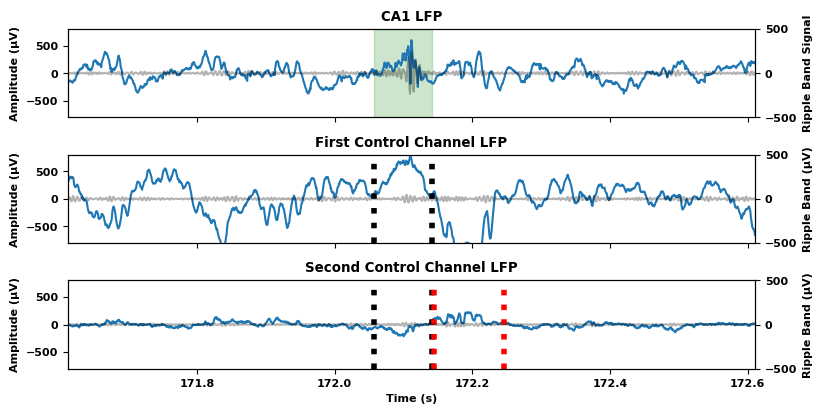

In [72]:
# Change the event number to pick a different ripple
rip_id = 29
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]*1e6
ripple_band_ca1_slice = ripple_band_ca1[mask]*1e6
linethickness = 4
riplim = 500
lfplim = 800

# Calculate global min and max for LFP data
lfp_min = min(np.min(ca1_lfp_data_slice), np.min(first_control_lfp_data[mask]), np.min(second_control_lfp_data[mask]))
lfp_max = max(np.max(ca1_lfp_data_slice), np.max(first_control_lfp_data[mask]), np.max(second_control_lfp_data[mask]))

# Calculate global min and max for ripple band data
ripple_min = min(np.min(ripple_band_ca1_slice), np.min(ripple_band_first_control[mask]), np.min(ripple_band_second_control[mask]))
ripple_max = max(np.max(ripple_band_ca1_slice), np.max(ripple_band_first_control[mask]), np.max(ripple_band_second_control[mask]))

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# Set figure size in millimeters
fig_width_mm = 210 # width in millimeters
fig_height_mm = 106.25  # height in millimeters
fig_width_in = fig_width_mm / 25.4  # convert to inches
fig_height_in = fig_height_mm / 25.4  # convert to inches
plt.figure(figsize=(fig_width_in, fig_height_in))  # set the figure size


plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('CA1 LFP')
#plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.gca().set_xticklabels([])
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        # Check if the event overlaps with gamma or movement
        if event.Overlaps_with_gamma or event.Overlaps_with_movement:
            plt.axvspan(event.start_time, event.end_time, color='red', alpha=0.2)
        else:
            plt.axvspan(event.start_time, event.end_time, color='green', alpha=0.2)

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax2.set_ylim(-riplim, riplim)
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))


plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, first_control_lfp_data[mask]*1e6)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('First Control Channel LFP')
#plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.gca().set_xticklabels([])
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)
        
        
# Iterate over all events in first_artifact_df
for idx, row in first_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)

# Add the ripple band for the first control channel
ax4 = plt.twinx()  # Create a second y-axis
ax4.plot(time_arr_slice, ripple_band_first_control[mask]*1e6, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax4.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax4.set_ylabel('Ripple Band (µV)')  # Set label for the second y-axis
ax4.set_ylim(-riplim, riplim)
#ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, second_control_lfp_data[mask]*1e6)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('Second Control Channel LFP') 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)

# Iterate over all events in second_artifact_df
for idx, row in second_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)
        
# Add the ripple band for the second control channel
ax6 = plt.twinx()  # Create a second y-axis
ax6.plot(time_arr_slice, ripple_band_second_control[mask]*1e6, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax6.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax6.set_ylabel('Ripple Band (µV)')  # Set label for the second y-axis
ax6.set_ylim(-riplim, riplim)
#ax6.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

plt.savefig(f"{figure_four_path}/four_a_mm.svg", format='svg')
plt.tight_layout()
plt.show()

In [73]:
swr_df[swr_df['Overlaps_with_movement']==True].sort_values('duration').head(10)

event_number   start_time     end_time  duration  mean_zscore  \
36             39   303.300095   303.352761  0.052667     1.955009   
497           523  2202.272021  2202.325355  0.053333     2.197448   
587           621  2379.062743  2379.119410  0.056667     2.961864   
460           484  2158.866008  2158.924008  0.058000     1.417612   
337           350  1807.564565  1807.623231  0.058667     6.295863   
351           366  1844.401909  1844.465910  0.064000     3.292973   
197           206  1322.359080  1322.426413  0.067333     2.000231   
265           275  1510.573139  1510.641139  0.068000    10.081460   
14             16    98.258031    98.326697  0.068667     3.574068   
335           348  1805.188564  1805.259897  0.071333     6.368234   

     median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
36        1.127038    4.670553    0.029090   303.333428                False   
497       2.251855    4.561808    0.032595  2202.304688                False   
587       2.579648    6.465327    0.000270  2379.097410                False   
460       1.459360    3.074877    0.005421  2158.907341                False   
337       2.630870   19.384033    0.023330  1807.595231                 True   
351       1.587644   10.220644    0.010976  1844.433910                False   
197       1.192067    4.897774    0.012515  1322.375746                 True   
265       8.156676   25.303723    0.000517  1510.609139                False   
14        3.311438    8.297568    0.024516    98.287364                False   
335       3.611110   18.219762    0.002017  1805.219231                False   

     Overlaps_with_movement  
36                     True  
497                    True  
587                    True  
460                    True  
337                    True  
351                    True  
197                    True  
265                    True  
14                     True  
335                    True

In [74]:
import matplotlib.ticker as ticker

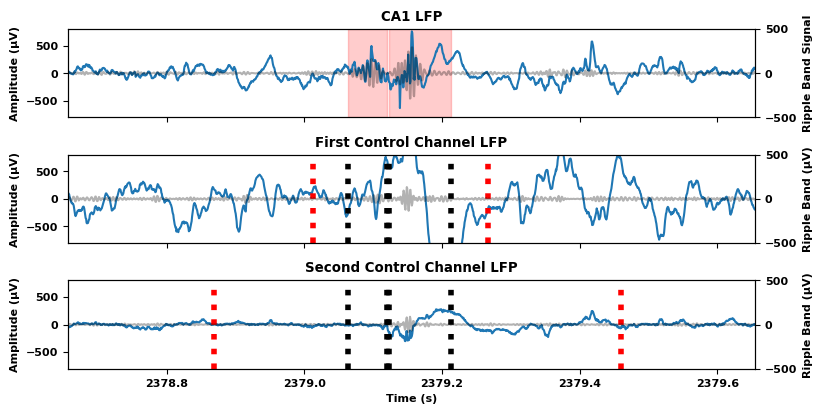

In [75]:
# Change the event number to pick a different ripple
rip_id = 622
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]*1e6
ripple_band_ca1_slice = ripple_band_ca1[mask]*1e6
linethickness = 4
riplim = 500
lfplim = 800

# Calculate global min and max for LFP data
lfp_min = min(np.min(ca1_lfp_data_slice), np.min(first_control_lfp_data[mask]), np.min(second_control_lfp_data[mask]))
lfp_max = max(np.max(ca1_lfp_data_slice), np.max(first_control_lfp_data[mask]), np.max(second_control_lfp_data[mask]))

# Calculate global min and max for ripple band data
ripple_min = min(np.min(ripple_band_ca1_slice), np.min(ripple_band_first_control[mask]), np.min(ripple_band_second_control[mask]))
ripple_max = max(np.max(ripple_band_ca1_slice), np.max(ripple_band_first_control[mask]), np.max(ripple_band_second_control[mask]))

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# Set figure size in millimeters
fig_width_mm = 210 # width in millimeters
fig_height_mm = 106.25  # height in millimeters
fig_width_in = fig_width_mm / 25.4  # convert to inches
fig_height_in = fig_height_mm / 25.4  # convert to inches
plt.figure(figsize=(fig_width_in, fig_height_in))  # set the figure size

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('CA1 LFP')
#plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.gca().set_xticklabels([])
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        # Check if the event overlaps with gamma or movement
        if event.Overlaps_with_gamma or event.Overlaps_with_movement:
            plt.axvspan(event.start_time, event.end_time, color='red', alpha=0.2)
        else:
            plt.axvspan(event.start_time, event.end_time, color='green', alpha=0.2)

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax2.set_ylim(-riplim, riplim)
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))


plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, first_control_lfp_data[mask]*1e6)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('First Control Channel LFP')
#plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.gca().set_xticklabels([])
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)
        
        
# Iterate over all events in first_artifact_df
for idx, row in first_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)

# Add the ripple band for the first control channel
ax4 = plt.twinx()  # Create a second y-axis
ax4.plot(time_arr_slice, ripple_band_first_control[mask]*1e6, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax4.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax4.set_ylabel('Ripple Band (µV)')  # Set label for the second y-axis
ax4.set_ylim(-riplim, riplim)
#ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, second_control_lfp_data[mask]*1e6)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('Second Control Channel LFP') 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)

# Iterate over all events in second_artifact_df
for idx, row in second_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)
        
# Add the ripple band for the second control channel
ax6 = plt.twinx()  # Create a second y-axis
ax6.plot(time_arr_slice, ripple_band_second_control[mask]*1e6, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax6.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax6.set_ylabel('Ripple Band (µV)')  # Set label for the second y-axis
ax6.set_ylim(-riplim, riplim)
#ax6.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

plt.savefig(f"{figure_four_path}/four_b_mm.svg", format='svg')
plt.tight_layout()
plt.show()

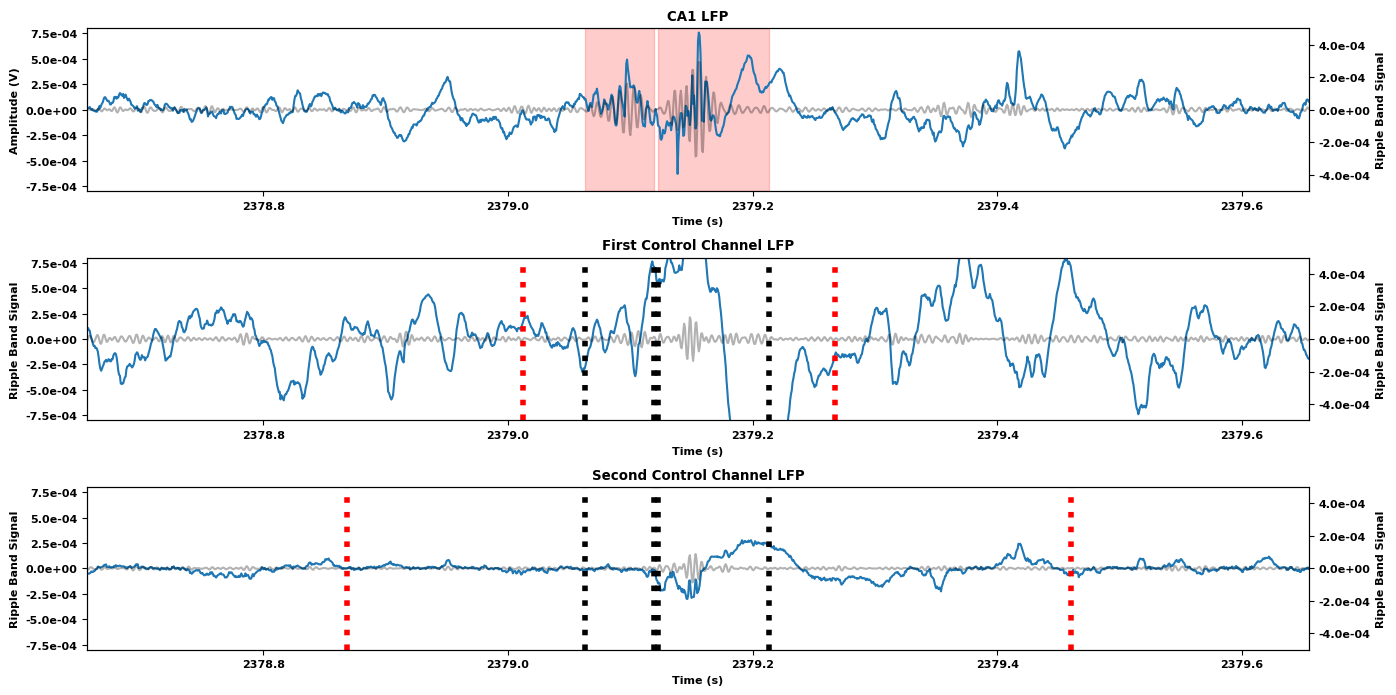

In [76]:
# Change the event number to pick a different ripple
rip_id = 622
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]
ripple_band_ca1_slice = ripple_band_ca1[mask]
linethickness = 4
riplim = 0.0005
lfplim = 0.0008

# Calculate global min and max for LFP data
lfp_min = min(np.min(ca1_lfp_data_slice), np.min(first_control_lfp_data[mask]), np.min(second_control_lfp_data[mask]))
lfp_max = max(np.max(ca1_lfp_data_slice), np.max(first_control_lfp_data[mask]), np.max(second_control_lfp_data[mask]))

# Calculate global min and max for ripple band data
ripple_min = min(np.min(ripple_band_ca1_slice), np.min(ripple_band_first_control[mask]), np.min(ripple_band_second_control[mask]))
ripple_max = max(np.max(ripple_band_ca1_slice), np.max(ripple_band_first_control[mask]), np.max(ripple_band_second_control[mask]))

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams['pdf.use14corefonts'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        # Check if the event overlaps with gamma or movement
        if event.Overlaps_with_gamma or event.Overlaps_with_movement:
            plt.axvspan(event.start_time, event.end_time, color='red', alpha=0.2)
        else:
            plt.axvspan(event.start_time, event.end_time, color='green', alpha=0.2)

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax2.set_ylim(-riplim, riplim)
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))


plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, first_control_lfp_data[mask])
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('First Control Channel LFP')
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)
        
        
# Iterate over all events in first_artifact_df
for idx, row in first_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)

# Add the ripple band for the first control channel
ax4 = plt.twinx()  # Create a second y-axis
ax4.plot(time_arr_slice, ripple_band_first_control[mask], color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax4.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax4.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis
ax4.set_ylim(-riplim, riplim)
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, second_control_lfp_data[mask])
plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('Second Control Channel LFP') 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

# Iterate over all events in swr_df
for _, event in swr_df.iterrows():
    # Check if the event occurs in the time slice
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted',linewidth=linethickness)
        plt.axvline(x=event.end_time, color='black', linestyle='dotted',linewidth=linethickness)

# Iterate over all events in second_artifact_df
for idx, row in second_artifact_df.iterrows():
    # Check if the event overlaps with the time slice
    if row['start_time'] < time_arr_slice[-1] and row['end_time'] > time_arr_slice[0]:
        plt.axvline(x=row['start_time'], color='red', linestyle='dotted', linewidth=linethickness)
        plt.axvline(x=row['end_time'], color='red', linestyle='dotted', linewidth=linethickness)
        
# Add the ripple band for the second control channel
ax6 = plt.twinx()  # Create a second y-axis
ax6.plot(time_arr_slice, ripple_band_second_control[mask], color='black', alpha=0.3)  # Plot on the second y-axis with black color
ax6.set_ylim(ripple_min, ripple_max)  # Set y-limits to global min and max
ax6.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis
ax6.set_ylim(-riplim, riplim)
ax6.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

plt.savefig(f"{figure_four_path}/four_b.svg", format='svg')
plt.tight_layout()
plt.show()

In [77]:
swr_df[(swr_df['Overlaps_with_movement']==False) & (swr_df['Overlaps_with_gamma']==False)].sort_values('max_zscore', ascending=False).head(10)

event_number   start_time     end_time  duration  mean_zscore  \
93             96   710.893555   711.028222  0.134667     5.772133   
311           323  1728.815207  1728.936540  0.121333     8.118224   
69             72   536.015501   536.072167  0.056667     9.419180   
317           330  1773.157221  1773.286554  0.129333     3.767396   
319           332  1776.327222  1776.417222  0.090000     7.249672   
354           369  1849.233244  1849.320578  0.087333     7.178831   
190           199  1267.951729  1268.079729  0.128000     4.421469   
170           178  1132.081687  1132.216354  0.134667     7.303685   
340           353  1814.561234  1814.653900  0.092667     6.617774   
298           309  1671.085189  1671.241855  0.156667     3.961716   

     median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
93        1.360401   30.025266    0.030431   710.967555                False   
311       4.492035   25.731307    0.012713  1728.857873                False   
69        6.621874   24.554449    0.028908   536.042167                False   
317       0.560085   23.355002    0.011441  1773.237887                False   
319       4.125804   22.396385    0.021242  1776.355888                False   
354       3.008206   22.039039    0.008441  1849.266578                False   
190       1.320305   21.355201    0.017884  1268.045063                False   
170       6.235302   21.275243    0.009555  1132.141687                False   
340       1.754542   21.069848    0.013826  1814.603900                False   
298       1.322567   20.672179    0.001173  1671.171855                False   

     Overlaps_with_movement  
93                    False  
311                   False  
69                    False  
317                   False  
319                   False  
354                   False  
190                   False  
170                   False  
340                   False  
298                   False

In [78]:
zscored_gamma_band_ca1 = stats.zscore(abs(scipy.signal.hilbert(gamma_band_ca1))**2)

In [79]:
gamma_events_df

Unnamed: 0   start_time     end_time  duration
0              4     2.802001     2.819334  0.017333
1              7     3.440001     3.459334  0.019333
2              9     3.509334     3.563334  0.054000
3             18     9.179336     9.196670  0.017333
4             23    12.474004    12.491337  0.017333
...          ...          ...          ...       ...
997         4312  2532.070791  2532.099458  0.028667
998         4314  2532.152791  2532.170791  0.018000
999         4315  2532.181458  2532.204791  0.023333
1000        4318  2536.112126  2536.130792  0.018667
1001        4324  2558.318799  2558.343466  0.024667

[1002 rows x 4 columns]

In [80]:
swr_df[(swr_df['Overlaps_with_movement']==False) & (swr_df['Overlaps_with_gamma']==True)].sort_values('max_zscore').head(10)

event_number   start_time     end_time  duration  mean_zscore  \
138           145   962.271634   962.318967  0.047333     1.670357   
537           568  2261.808040  2261.897373  0.089333     1.461272   
40             43   346.360108   346.414775  0.054667     1.269781   
174           182  1156.395695  1156.485695  0.090000     1.022008   
364           379  1859.643248  1859.709914  0.066667     1.249006   
540           571  2262.634040  2262.714040  0.080000     1.049866   
363           378  1859.564581  1859.635248  0.070667     1.581221   
172           180  1147.615692  1147.673025  0.057333     1.523052   
286           297  1599.927833  1599.967833  0.040000     1.715926   
226           235  1405.757106  1405.857106  0.100000     0.966009   

     median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
138       1.688909    3.149171    0.008370   962.289634                 True   
537       1.310887    3.153515    0.001968  2261.856040                 True   
40        0.784883    3.276520    0.007247   346.387442                 True   
174       0.405270    3.314326    0.006785  1156.435028                 True   
364       0.703479    3.356464    0.001035  1859.681248                 True   
540       0.613910    3.470644    0.002238  2262.680707                 True   
363       1.482690    3.489172    0.040068  1859.613914                 True   
172       1.160176    3.548304    0.003409  1147.649025                 True   
286       1.452577    3.576614    0.030860  1599.945166                 True   
226       0.672221    3.597642    0.009358  1405.803772                 True   

     Overlaps_with_movement  
138                   False  
537                   False  
40                    False  
174                   False  
364                   False  
540                   False  
363                   False  
172                   False  
286                   False  
226                   False

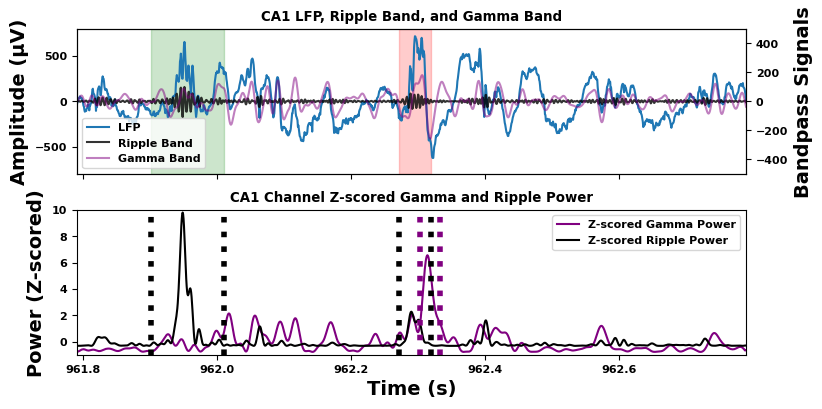

In [81]:
from scipy.stats import zscore

# Change the event number to pick a different ripple
rip_id = 145 
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]*1e6
ca1_ripple_power_slice = ripple_band_ca1[mask]*1e6
zscored_ripple_power_ca1_slice = zscore(abs(signal.hilbert(ripple_band_ca1[mask])**2))  # Compute z-scored ripple band power
gamma_band_ca1_slice = gamma_band_ca1[mask]*1e6
zscored_gamma_power_ca1_slice = zscore(abs(signal.hilbert(gamma_band_ca1[mask])**2))  # Compute z-scored gamma band power
linethickness = 4
riplim = 500
lfplim = 800

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams['pdf.use14corefonts'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"


# Set figure size in millimeters
figure_width_mm = 210  # width in millimeters
figure_height_mm = 105  # height in millimeters

# Convert to inches
figure_width_in = figure_width_mm / 25.4  # width in inches
figure_height_in = figure_height_mm / 25.4  # height in inches

# Create figure with specified size
plt.figure(figsize=(figure_width_in, figure_height_in))

plt.subplot(2, 1, 1)
plt.plot(time_arr_slice, ca1_lfp_data_slice, label='LFP')
plt.plot(time_arr_slice, ca1_ripple_power_slice, color='black', alpha=0.8, label='Ripple Band')  # Plot ripple band
plt.plot(time_arr_slice, gamma_band_ca1_slice, color='purple', alpha=0.5, label='Gamma Band')  # Plot gamma band

# Plot probe level events with shaded areas
for _, event in swr_df.iterrows():
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1] and event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        if event.Overlaps_with_gamma:
            plt.axvspan(xmin=event.start_time, xmax=event.end_time, color='red', alpha=0.2)
        else:
            plt.axvspan(xmin=event.start_time, xmax=event.end_time, color='green', alpha=0.2)

plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-lfplim, lfplim)
plt.title('CA1 LFP, Ripple Band, and Gamma Band')
#plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)', fontsize=14, weight = 'bold')
plt.gca().set_xticklabels([])
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

plt.legend()

ax2 = plt.twinx()  # Create a second y-axis
ax2.set_ylim(-riplim, riplim)
ax2.set_ylabel('Bandpass Signals', fontsize=14, weight = 'bold')  # Set label for the second y-axis
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1e}'.format(y)))

plt.subplot(2, 1, 2)
plt.plot(time_arr_slice, zscored_gamma_power_ca1_slice, color='purple', alpha=1, label='Z-scored Gamma Power') 
plt.plot(time_arr_slice, zscored_ripple_power_ca1_slice, color='black', alpha=1, label='Z-scored Ripple Power')  # Plot z-scored ripple band power

for _, event in gamma_events_df.iterrows():
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='purple', linestyle='dotted', linewidth=linethickness)
    if event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.end_time, color='purple', linestyle='dotted', linewidth=linethickness)

# Plot probe level events with dotted black lines
for _, event in swr_df.iterrows():
    if event.start_time > time_arr_slice[0] and event.start_time < time_arr_slice[-1]:
        plt.axvline(x=event.start_time, color='black', linestyle='dotted', linewidth=linethickness)
    if event.end_time > time_arr_slice[0] and event.end_time < time_arr_slice[-1]:
        plt.axvline(x=event.end_time, color='black', linestyle='dotted', linewidth=linethickness)

plt.xlim(time_arr_slice[0], time_arr_slice[-1])
plt.ylim(-1, 10)
plt.title('CA1 Channel Z-scored Gamma and Ripple Power') 
plt.xlabel('Time (s)', fontsize=14, weight = 'bold')
plt.ylabel('Power (Z-scored)', fontsize=14, weight = 'bold')
plt.legend()
plt.savefig(f"{figure_five_path}/five_a.svg", format='svg')
plt.tight_layout()
plt.show()

In [82]:
movement_artifacts_df = swr_df[swr_df['Overlaps_with_movement']==True]
movement_artifacts_df

event_number   start_time     end_time  duration  mean_zscore  \
0               1     1.410667     1.510667  0.100000     3.625943   
10             12    52.014683    52.088016  0.073333     1.176454   
11             13    69.722688    69.802688  0.080000     1.586799   
13             15    89.892028    90.044695  0.152667     3.198855   
14             16    98.258031    98.326697  0.068667     3.574068   
..            ...          ...          ...       ...          ...   
640           681  2529.958124  2530.076124  0.118000     5.047864   
641           682  2530.710791  2530.816791  0.106000     5.791915   
643           684  2531.421457  2531.587457  0.166000     2.793609   
644           685  2531.592124  2531.706791  0.114667     3.777220   
645           686  2532.061458  2532.212124  0.150667     2.992282   

     median_zscore  max_zscore  min_zscore    Peak_time  Overlaps_with_gamma  \
0         2.199558   12.195477    0.015032     1.461334                False   
10        0.872736    3.133274    0.015170    52.056683                False   
11        0.796645    5.368223    0.019646    69.779355                 True   
13        1.828017   15.834397    0.002288    89.929361                 True   
14        3.311438    8.297568    0.024516    98.287364                False   
..             ...         ...         ...          ...                  ...   
640       2.959198   14.132357    0.005524  2530.028124                False   
641       3.482918   17.468356    0.004916  2530.768791                False   
643       1.338538   14.391640    0.007401  2531.513457                False   
644       1.629299   15.517908    0.011813  2531.644124                False   
645       1.544284   10.915838    0.009613  2532.115458                 True   

     Overlaps_with_movement  
0                      True  
10                     True  
11                     True  
13                     True  
14                     True  
..                      ...  
640                    True  
641                    True  
643                    True  
644                    True  
645                    True  

[204 rows x 11 columns]

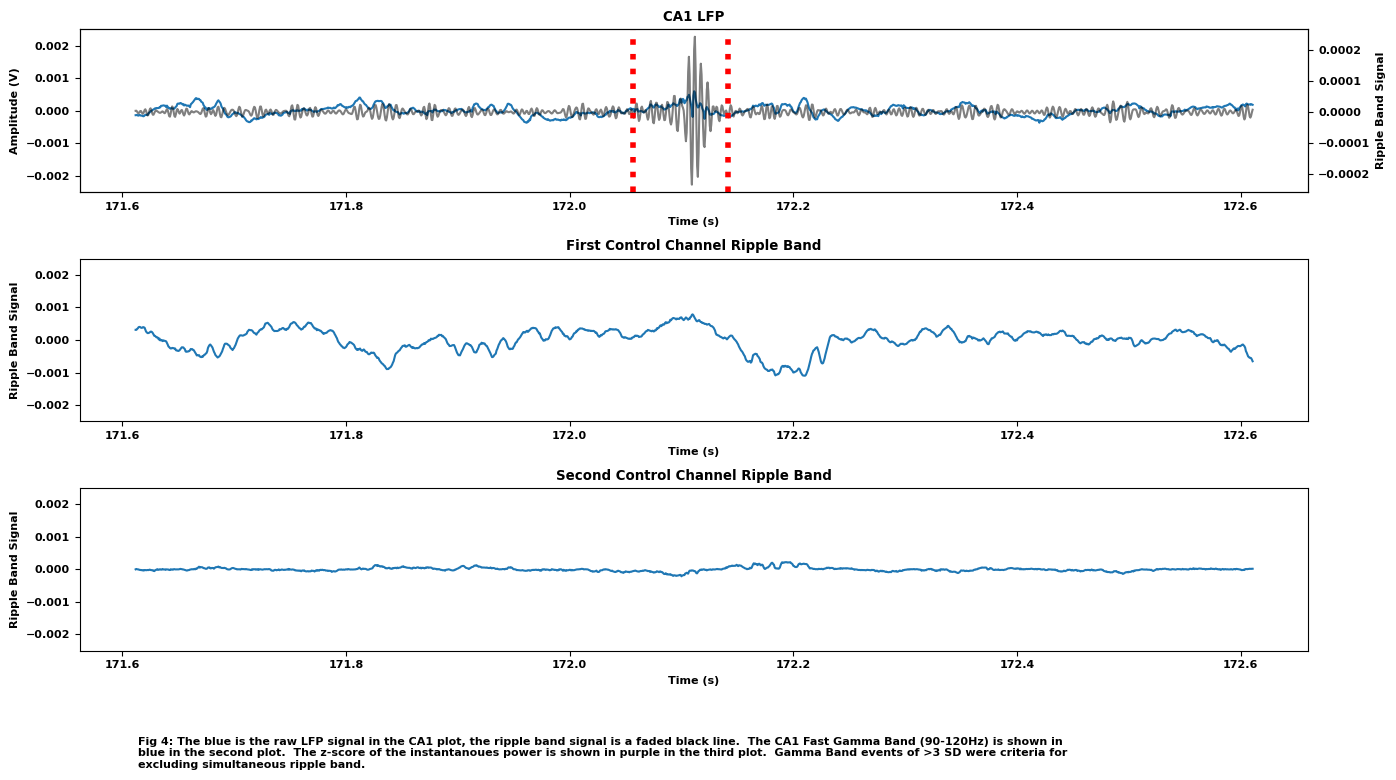

In [83]:
# Change the event number to pick a different ripple
rip_id = 29
peaktime = swr_df.Peak_time[swr_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_lfp_data_slice = ca1_lfp_data[mask]
ripple_band_ca1_slice = ripple_band_ca1[mask]
lfp_plot_lim = 0.0025
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_lfp_data_slice)
plt.ylim(-lfp_plot_lim, lfp_plot_lim)
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ripple_band_ca1_slice, color='black', alpha=0.5)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

# Add red dotted lines
rip_start_time = swr_df.start_time[swr_df.event_number == rip_id].values[0]
plt.axvline(x=rip_start_time, color='r', linestyle=':', linewidth=4)
rip_end_time = swr_df.end_time[swr_df.event_number == rip_id].values[0]
plt.axvline(x=rip_end_time, color='r', linestyle=':', linewidth=4)

plt.subplot(3, 1, 2)
#plt.plot(time_arr_slice, ripple_band_first_control[mask])
#plt.plot(time_arr_slice, np.squeeze(ripple_band_first_control[mask]))
plt.plot(time_arr_slice, first_control_lfp_data[mask])
plt.ylim(-lfp_plot_lim, lfp_plot_lim)
plt.title('First Control Channel Ripple Band')
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

plt.subplot(3, 1, 3)

#plt.plot(time_arr_slice, ripple_band_second_control[mask], color='purple', alpha=0.5) 
#plt.plot(time_arr_slice, np.squeeze(ripple_band_second_control[mask]))
plt.plot(time_arr_slice, np.squeeze(second_control_lfp_data[mask]))
plt.ylim(-lfp_plot_lim, lfp_plot_lim)
plt.title('Second Control Channel Ripple Band') 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Band Signal')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 4: The blue is the raw LFP signal in the CA1 plot, the ripple band signal is a faded black line.  The CA1 Fast Gamma Band (90-120Hz) is shown in \nblue in the second plot.  The z-score of the instantanoues power is shown in purple in the third plot.  Gamma Band events of >3 SD were criteria for \nexcluding simultaneous ripple band.", ha="left")

plt.tight_layout()
plt.show()

## Csd and Multitrace plot

In [84]:
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions

ba = AllenAtlas()
br = BrainRegions() # br is also an attribute of ba so could to br = ba.regions


In [85]:
# compute csd code
# try averaging between channels at the same depth, then providing that
# microns to microvolts means that microns can be in the same scale
def average_channels(electrode_data):
    """Calculate the average of every pair of even and odd channels"""
    nchan = electrode_data.shape[1]
    mask = np.full(nchan, False, dtype=bool)
    #print("mask length " + str(len(mask)))
    # Set True at even indices
    mask[::2] = True
    even_channels = electrode_data[:,mask]
    #print("even_channels shape" + str(even_channels.shape))
    odd_channels = electrode_data[:,~mask]  
    #print("odd_channels" + str(odd_channels.shape))
    # Calculate the average
    #averaged_data = np.average([even_channels, odd_channels_without_last], axis=0)

    averaged_data = (even_channels+odd_channels)/2

    return averaged_data
    
def butterworth_filter_for_csd(LFP_array, lowcut = 1.0, highcut = 250.0,
                    samplingfreq = 2500.0, order = 6):

    nyquist = 0.5 * samplingfreq
    # Design the Butterworth bandpass filter
    # Design the Butterworth bandpass filter
    b, a = signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')

    # Apply the filter to all channels simultaneously using vectorized operations
    filtered_signal = signal.lfilter(b, a, LFP_array, axis=0)
    return(filtered_signal)

# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_csd(LFP_array, lowcut = 1, highcut = 250,
                    samplingfreq = 2500, filter_order =101):

    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(filter_order, [lowcut / nyquist, highcut / nyquist],
                                pass_zero=False, fs=samplingfreq)

    # Apply the FIR filter to your signal_array
    #filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)
    
    return(filtered_signal)

def compute_csd(lfp_data, spacing_between_channels, chan_rows):
    """
    Compute Current Source Density (CSD) from Local Field Potential (LFP) data.

    Parameters:
        lfp_data (numpy.ndarray): 2D array of LFP data, shape (n_channels, n_samples).
        spacing_between_channels (float): Distance (in micrometers) between adjacent channels.
        chan_rows list of int :  the index on the 2d dimension of lfp data for which channels are to be included

    Returns:
        csd_data (numpy.ndarray): 2D array of CSD data, shape (n_channels, n_samples).
    """
    # Ensure the input LFP data is a NumPy array
    lfp_data = np.array(lfp_data)
    lfp_data = lfp_data[:,chan_rows]

    lfp_data = finitimpresp_filter_for_csd(lfp_data)
    lfp_data = average_channels(lfp_data)

    # Get the number of channels and samples
    n_channels, n_samples = lfp_data.shape

    # Define the finite difference coefficients for second spatial derivative
    fd_coefficients = np.array([1, -2, 1]) / spacing_between_channels**2

    # Function to compute CSD for a single channel
    def compute_csd_single_channel(channel_data):
        return np.convolve(channel_data, fd_coefficients, mode='same')

    # Apply the second spatial derivative to each channel using apply_along_axis
    csd_data = np.apply_along_axis(compute_csd_single_channel, axis=0, arr=lfp_data)

    return csd_data


def exponential_smoothing_2d(data, alpha, axis):
    """
    Apply exponential smoothing to a 2D NumPy array along the specified axis.

    Parameters:
    - data: Input 2D NumPy array
    - alpha: Smoothing parameter (0 < alpha < 1)
    - axis: Axis along which to apply exponential smoothing (0 for rows, 1 for columns)

    Returns:
    - smoothed_data: Exponentially smoothed array
    """

    if axis not in (0, 1):
        raise ValueError("Axis must be 0 (rows) or 1 (columns).")

    smoothed_data = np.copy(data)

    if axis == 0:
        for i in range(data.shape[1]):
            smoothed_data[:, i] = exponential_smoothing(data[:, i], alpha)
    elif axis == 1:
        for i in range(data.shape[0]):
            smoothed_data[i, :] = exponential_smoothing(data[i, :], alpha)

    return smoothed_data

def exponential_smoothing(series, alpha):
    """
    Apply exponential smoothing to a 1D NumPy array.

    Parameters:
    - series: Input 1D NumPy array
    - alpha: Smoothing parameter (0 < alpha < 1)

    Returns:
    - smoothed_series: Exponentially smoothed array
    """

    smoothed_series = np.zeros_like(series)
    smoothed_series[0] = series[0]

    for t in range(1, len(series)):
        smoothed_series[t] = alpha * series[t] + (1 - alpha) * smoothed_series[t - 1]

    return smoothed_series

In [86]:
# pick a session based on largest ripple at lowest running speed
# and the peak probe it's on
# Convert speeds list to a pandas Series

speeds_series = pd.Series(speeds, name='speeds')

# Convert theta_data dict to a DataFrame
theta_df = pd.DataFrame(theta_powers)

# Reset the index of theta_df and test
theta_df = theta_df.reset_index(drop=True)

# Add speeds_series to all_swrs_df and reset index
all_swrs_df = all_swrs_df.assign(speeds=speeds_series)
all_swrs_df = all_swrs_df.reset_index(drop=True)

# Concatenate test and theta_df
all_swrs_df = pd.concat([all_swrs_df, theta_df], axis=1)


In [87]:
all_swrs_df.columns

Index(['start_time', 'end_time', 'probes_event_is_on', 'events_row_index',
       'global_peak_time', 'global_max_zscore', 'peak_probe', 'duration',
       'session_id', 'speeds', 'peakwindow_med', 'peakwindow_mean',
       'eventwindow_med', 'eventwindow_mean'],
      dtype='object')

In [88]:
# Sort by global_max_zscore in descending order
sorted_df = all_swrs_df

# Add quantile columns to sorted_df
sorted_df['speeds_quantile'] = pd.qcut(sorted_df['speeds'], q=4, labels=False)
sorted_df['peakwindow_mean_quantile'] = pd.qcut(sorted_df['peakwindow_mean'], q=4, labels=False)

# Filter sorted_df to only include rows in the lowest quantiles of speeds and peakwindow_mean
lowest_quantiles_df = sorted_df[(sorted_df['speeds_quantile'] == 0) & (sorted_df['peakwindow_mean_quantile'] == 0)]
lowest_quantiles_df = lowest_quantiles_df.sort_values(by='global_max_zscore', ascending=False)



In [89]:
# Initialize a dictionary to store the counts
probe_counts = {}

# Iterate over the first 100 rows of the DataFrame
for _, row in lowest_quantiles_df.head(100).iterrows():
    probe_id = row['peak_probe']
    session_id = row['session_id']
    
    probes_list, probenames = one.eid2pid(session_id)
    probes_list = np.array(probes_list)
    probenames = np.array(probenames)
    
    probe_name = probenames[probes_list == probe_id]
    if probe_name.size > 0:
        probe_name = probe_name[0]
        collectionname = f'alf/{probe_name}/pykilosort'
        
        # Load the channels
        channels = one.load_object(session_id, 'channels', collection=collectionname)
        channels.allen2017_25um_acronym = br.id2acronym(channels['brainLocationIds_ccf_2017'])
        
        # Count the number of ca1 channels
        ca1_count = np.sum(channels['allen2017_25um_acronym'] == 'CA1')
        
        # Update the count for this probe
        if probe_id in probe_counts:
            probe_counts[probe_id] = (probe_counts[probe_id][0] + ca1_count, session_id)
        else:
            probe_counts[probe_id] = (ca1_count, session_id)

# Find the probe with the most number of ca1 channels
max_probe = max(probe_counts, key=lambda x: probe_counts[x][0])

print(f'The probe with the most number of CA1 channels is: {max_probe} from session: {probe_counts[max_probe][1]}')

The probe with the most number of CA1 channels is: 30ac1320-d671-46fc-87ef-875cdfc6b4eb from session: edd22318-216c-44ff-bc24-49ce8be78374


In [90]:
# Initialize a dictionary to store the counts and scores
probe_counts_scores = {}

# Iterate over the first 100 rows of the DataFrame
for _, row in lowest_quantiles_df.head(100).iterrows():
    probe_id = row['peak_probe']
    session_id = row['session_id']
    global_max_zscore = row['global_max_zscore']
    
    probes_list, probenames = one.eid2pid(session_id)
    probes_list = np.array(probes_list)
    probenames = np.array(probenames)
    
    probe_name = probenames[probes_list == probe_id]
    if probe_name.size > 0:
        probe_name = probe_name[0]
        collectionname = f'alf/{probe_name}/pykilosort'
        
        # Load the channels
        channels = one.load_object(session_id, 'channels', collection=collectionname)
        channels.allen2017_25um_acronym = br.id2acronym(channels['brainLocationIds_ccf_2017'])
        
        # Count the number of ca1 channels
        ca1_count = np.sum(channels['allen2017_25um_acronym'] == 'CA1')
        
        # Update the count and score for this probe
        if probe_id in probe_counts_scores:
            probe_counts_scores[probe_id].append((ca1_count, global_max_zscore, row))
        else:
            probe_counts_scores[probe_id] = [(ca1_count, global_max_zscore, row)]

# Find the probe with the most number of ca1 channels and highest global_max_zscore
max_probe = max(probe_counts_scores, key=lambda x: max(probe_counts_scores[x], key=lambda y: (y[0], y[1])))

# Get the row with the most number of CA1 channels and highest global_max_zscore
desired_event = max(probe_counts_scores[max_probe], key=lambda x: (x[0], x[1]))[2]

print(f'The desired event is from probe: {desired_event.peak_probe} and session: {desired_event.session_id}')

The desired event is from probe: c0c3c95d-43c3-4e30-9ce7-0519d0473911 and session: 6c6983ef-7383-4989-9183-32b1a300d17a


In [91]:
lowest_quantiles_df.head()

start_time     end_time                        probes_event_is_on  \
1083  4302.557471  4302.697471  ['e31b4e39-e350-47a9-aca4-72496d99ff2a']   
3098  3813.667373  3813.882040  ['30ac1320-d671-46fc-87ef-875cdfc6b4eb']   
1039  4126.981436  4127.209437  ['e31b4e39-e350-47a9-aca4-72496d99ff2a']   
1115  4505.409510  4505.553510  ['e31b4e39-e350-47a9-aca4-72496d99ff2a']   
756   2727.754496  2727.964496  ['e31b4e39-e350-47a9-aca4-72496d99ff2a']   

     events_row_index  global_peak_time  global_max_zscore  \
1083            [778]       4302.646804          30.232441   
3098            [785]       3813.748040          26.819196   
1039            [732]       4127.143437          26.754735   
1115            [811]       4505.473510          26.092527   
756             [435]       2727.923163          25.807106   

                                peak_probe  duration  \
1083  e31b4e39-e350-47a9-aca4-72496d99ff2a  0.140000   
3098  30ac1320-d671-46fc-87ef-875cdfc6b4eb  0.214667   
1039  e31b4e39-e350-47a9-aca4-72496d99ff2a  0.228000   
1115  e31b4e39-e350-47a9-aca4-72496d99ff2a  0.144000   
756   e31b4e39-e350-47a9-aca4-72496d99ff2a  0.210000   

                                session_id    speeds  peakwindow_med  \
1083  746d1902-fa59-4cab-b0aa-013be36060d5  0.000110       -0.760943   
3098  edd22318-216c-44ff-bc24-49ce8be78374  0.000357       -0.416674   
1039  746d1902-fa59-4cab-b0aa-013be36060d5  0.000173       -0.733076   
1115  746d1902-fa59-4cab-b0aa-013be36060d5  0.000163       -0.489954   
756   746d1902-fa59-4cab-b0aa-013be36060d5  0.000079       -0.460677   

      peakwindow_mean  eventwindow_med  eventwindow_mean  speeds_quantile  \
1083        -0.579176        -0.806206         -0.778263              0.0   
3098        -0.377956        -0.226550         -0.250268              0.0   
1039        -0.645099        -0.829872         -0.819415              0.0   
1115        -0.490784        -0.525910         -0.516769              0.0   
756         -0.416115        -0.440054         -0.428765              0.0   

      peakwindow_mean_quantile  
1083                       0.0  
3098                       0.0  
1039                       0.0  
1115                       0.0  
756                        0.0

In [92]:
desired_event.peak_probe

'c0c3c95d-43c3-4e30-9ce7-0519d0473911'

In [93]:
#from one.api import ONE
from iblatlas.atlas import AllenAtlas, Insertion
from brainbox.io.one import SpikeSortingLoader


ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')
# Load in the channels
ssl = SpikeSortingLoader(pid=desired_event.peak_probe, one=one, atlas=ba)
channels = ssl.load_channels()
# Coordinates of each channel in 3D space relative to Bregma
xyz = np.c_[channels['x'], channels['y'], channels['z']]

# From the channels we can compute an insertion object
ins = Insertion.from_track(xyz, brain_atlas=ba)

# The entry point of this insertion object on the surface of the cortex is given by
entry = ins.entry

In [94]:
#from one.api import ONE
from iblatlas.atlas import AllenAtlas, Insertion
from brainbox.io.one import SpikeSortingLoader


In [95]:
ssl = SpikeSortingLoader(pid=desired_event.peak_probe, one=one, atlas=ba)
channels = ssl.load_channels()

In [96]:
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions

ba = AllenAtlas()
br = BrainRegions() # br is also an attribute of ba so could to br = ba.regions

# loading the lfp
probe_id = desired_event.peak_probe
session_id = desired_event.session_id

probe_id = desired_event.peak_probe
session_id = desired_event.session_id

probes_list, probenames = one.eid2pid(session_id) # probe_id is pid in the IBL tutorials
probes_list = np.array(probes_list)
probenames = np.array(probenames)
probe_name = probenames[probes_list == probe_id]
probe_name = probe_name[0]


del probes_list
del probenames
collectionname = f'alf/{probe_name}/pykilosort' # ensures channels are all from this probe
channels = one.load_object(session_id, 'channels', collection=collectionname)
channels.allen2017_25um_acronym = br.id2acronym( channels['brainLocationIds_ccf_2017'] )

regions_on_probe = np.unique(channels.allen2017_25um_acronym)

# Find the relevant datasets and download them
dsets = one.list_datasets(session_id, collection=f'raw_ephys_data/{probe_name}', filename='*.lf.*')
data_files, _ = one.load_datasets(session_id, dsets, download_only=False)
bin_file = next(df for df in data_files if df.suffix == '.cbin')

# Use spikeglx reader to read in the whole raw data
sr = spikeglx.Reader(bin_file)
ssl = SpikeSortingLoader(pid=probe_id, one=one)
t0 = ssl.samples2times(0, direction='forward') # get the time of the first sample
dt = (ssl.samples2times(1, direction='forward') - t0)*12 # get the time difference between samples at 2500Hz
lfp_time_index_og = np.arange(0, sr.shape[0])*dt + t0
# make time index
ssl = SpikeSortingLoader(pid=probe_id, one=one)
del ssl 
raw = sr[:, :-sr.nsync].T
fs_from_sr = sr.fs
del sr
destriped = destripe_lfp(raw, fs=fs_from_sr)
del raw

100%|██████████| 10/10.0 [00:07<00:00,  1.25it/s]


In [97]:
collectionname = f'alf/{probe_name}/pykilosort' # ensures channels are all from this probe
channels = one.load_object(session_id, 'channels', collection=collectionname)
print(channels.keys())
channels.allen2017_25um_acronym = br.id2acronym( channels['brainLocationIds_ccf_2017'] )
print(channels.keys())

dict_keys(['brainLocationIds_ccf_2017', 'labels', 'localCoordinates', 'mlapdv', 'rawInd'])
dict_keys(['brainLocationIds_ccf_2017', 'labels', 'localCoordinates', 'mlapdv', 'rawInd', 'allen2017_25um_acronym'])


In [98]:
desired_events_from_this_probe = lowest_quantiles_df[lowest_quantiles_df['probes_event_is_on']== desired_event.probes_event_is_on]
desired_events_from_this_probe.head(20)

start_time     end_time                        probes_event_is_on  \
3982   510.392084   510.449417  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3570     4.215335     4.251335  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3700    51.192009    51.419343  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3606    15.368004    15.411337  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3625    22.312005    22.379338  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3628    22.915338    22.992671  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3796    98.829350    98.872684  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3980   490.810747   490.834747  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
4000   639.792104   639.828771  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3627    22.610671    22.812005  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
4023   812.676132   812.743466  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3676    41.998008    42.061341  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3738    66.466678    66.556012  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3618    19.263338    19.350671  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3965   386.621397   386.696730  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3948   304.500050   304.580717  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
4470  2797.577120  2797.601786  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3930   257.729376   257.872709  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
4264  1981.482988  1981.525654  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
4395  2521.974408  2522.154408  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   

     events_row_index  global_peak_time  global_max_zscore  \
3982            [473]        510.412084           8.622310   
3570             [18]          4.237335           8.279594   
3700            [166]         51.396009           6.875427   
3606             [64]         15.392004           6.633173   
3625             [87]         22.351338           5.943804   
3628             [90]         22.936005           5.940639   
3796            [273]         98.840684           5.679346   
3980            [471]        490.821414           5.604528   
4000            [491]        639.811438           5.547182   
3627             [89]         22.621338           5.409629   
4023            [514]        812.686132           5.321936   
3676            [142]         42.015341           5.313810   
3738            [211]         66.500012           5.294250   
3618         [78, 79]         19.280004           5.162880   
3965            [455]        386.678064           5.141860   
3948            [438]        304.527384           5.075495   
4470            [968]       2797.588453           4.994589   
3930            [419]        257.757376           4.990495   
4264            [758]       1981.504988           4.967488   
4395            [892]       2522.107742           4.932736   

                                peak_probe  duration  \
3982  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.057333   
3570  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.036000   
3700  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.227333   
3606  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.043333   
3625  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.067333   
3628  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.077333   
3796  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.043333   
3980  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.024000   
4000  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.036667   
3627  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.201333   
4023  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.067333   
3676  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.063333   
3738  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.089333   
3618  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.087333   
3965  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.075333   
3948  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.080667   
4470  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.024667   
3930  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.143333   
4264  c0c3c95d-43c3-4e30-9ce7-0519d0473911 

In [99]:
desired_events_from_this_probe = desired_events_from_this_probe.sort_values('global_max_zscore', ascending=False)
desired_events_from_this_probe.head(5)

start_time    end_time                        probes_event_is_on  \
3982  510.392084  510.449417  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3570    4.215335    4.251335  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3700   51.192009   51.419343  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3606   15.368004   15.411337  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   
3625   22.312005   22.379338  ['c0c3c95d-43c3-4e30-9ce7-0519d0473911']   

     events_row_index  global_peak_time  global_max_zscore  \
3982            [473]        510.412084           8.622310   
3570             [18]          4.237335           8.279594   
3700            [166]         51.396009           6.875427   
3606             [64]         15.392004           6.633173   
3625             [87]         22.351338           5.943804   

                                peak_probe  duration  \
3982  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.057333   
3570  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.036000   
3700  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.227333   
3606  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.043333   
3625  c0c3c95d-43c3-4e30-9ce7-0519d0473911  0.067333   

                                session_id    speeds  peakwindow_med  \
3982  6c6983ef-7383-4989-9183-32b1a300d17a  0.000036       -0.265587   
3570  6c6983ef-7383-4989-9183-32b1a300d17a  0.000297       -0.279364   
3700  6c6983ef-7383-4989-9183-32b1a300d17a  0.000234       -0.229871   
3606  6c6983ef-7383-4989-9183-32b1a300d17a  0.000118       -0.315788   
3625  6c6983ef-7383-4989-9183-32b1a300d17a  0.000158       -0.140214   

      peakwindow_mean  eventwindow_med  eventwindow_mean  speeds_quantile  \
3982        -0.270428        -0.269695         -0.272015              0.0   
3570        -0.278777        -0.295506         -0.290953              0.0   
3700        -0.242466        -0.162029         -0.186049              0.0   
3606        -0.316755        -0.299206         -0.300232              0.0   
3625        -0.154092        -0.045766         -0.060465              0.0   

      peakwindow_mean_quantile  
3982                       0.0  
3570                       0.0  
3700                       0.0  
3606                       0.0  
3625                       0.0

In [100]:
desired_event = desired_events_from_this_probe.iloc[5]

In [101]:
channels.keys()

dict_keys(['brainLocationIds_ccf_2017', 'labels', 'localCoordinates', 'mlapdv', 'rawInd', 'allen2017_25um_acronym'])

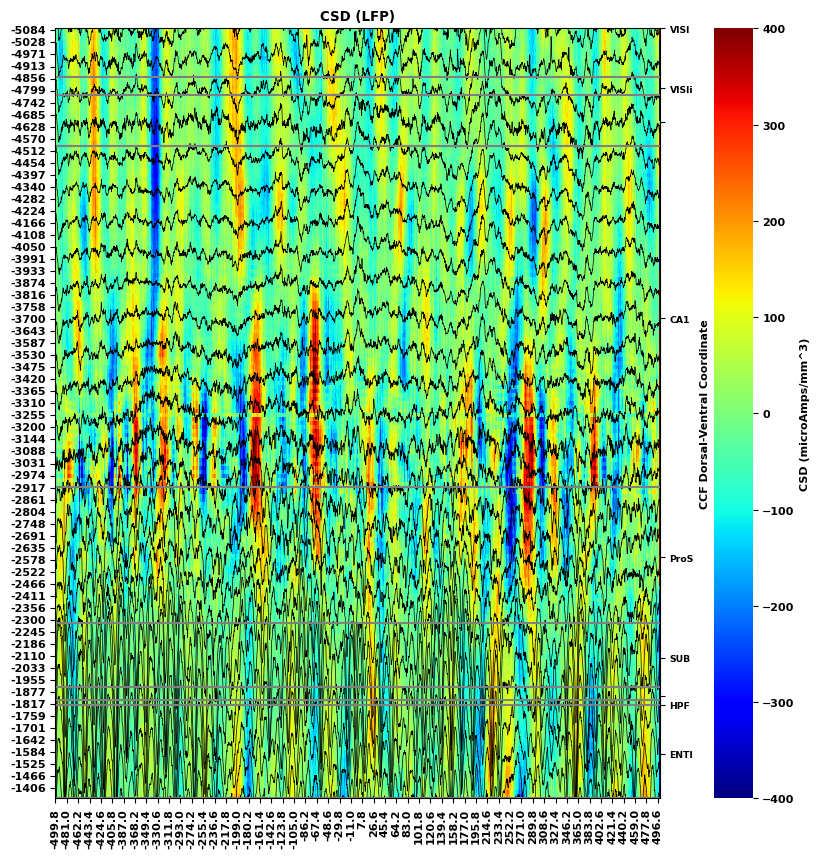

In [102]:
offset = 0.5
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time-offset)) & (lfp_time_index_og <= (desired_event.global_peak_time+offset))

lfp_slice = destriped[:,event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(lfp_slice.T, spacing_between_channels=20, chan_rows =channels['rawInd'])
#time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms*1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0) 
sig = scaled_filtered_smoothed_csd.shape[1] / 10.0  # Proportional to the size of the array
# Apply Gaussian smoothing
#scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
#scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
#scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-400] = -400

#depth (y)
ccf_dorsal_ventral = channels['mlapdv'][:,2]
allen_ontology_annot_og = channels['allen2017_25um_acronym']
mask = np.full(current_sink_this_rip.shape[1]*2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
#ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask] 
# simplify the names...
allen_ontology_annot = ['' if s.islower() else 'VISl' if 'VISl' in s and not 'VISli' in s else 'VISli' if 'VISli' in s else 'ENTl' if 'ENTl' in s else s for s in allen_ontology_annot]

#allen_ontology_annot = np.flip(allen_ontology_annot)
#allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen/10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen/10), dtype=int)


plt.figure(figsize=(10*offset*2, 10))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f", cmap="jet") #"Spectral_r" or "vlag" # RdYlBu_r


# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 8
trace_arr = lfp_slice[1::nth_probe]  

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

# Compute the median for each row in the DataFrame
trace_medians = np.median(trace_arr, axis=1)

for i, trace in enumerate(trace_arr):
    
    # Subtract the median from the trace
    trace = trace - trace_medians[i]
    
    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * nth_probe  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color='black', linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot)) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize='small')

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color='grey')

plt.title("CSD (LFP)")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
filepathandname = '/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure_three_d.svg'
plt.savefig(filepathandname, format='svg')
plt.show()

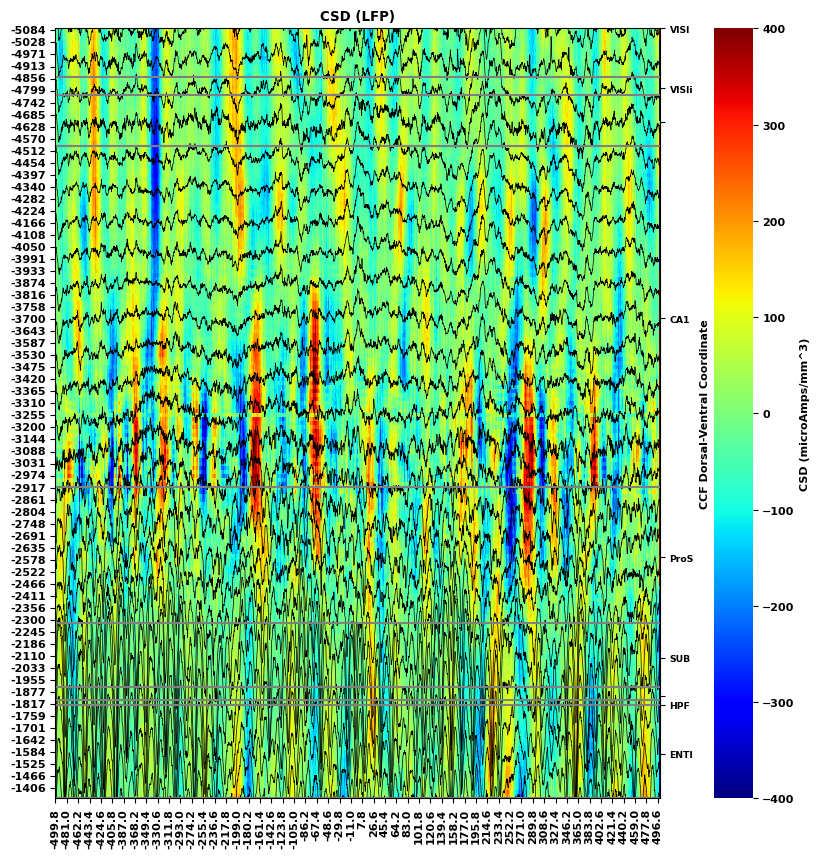

In [103]:
offset = 0.5
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time-offset)) & (lfp_time_index_og <= (desired_event.global_peak_time+offset))

lfp_slice = destriped[:,event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(lfp_slice.T, spacing_between_channels=20, chan_rows =channels['rawInd'])
#time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms*1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0) 
sig = scaled_filtered_smoothed_csd.shape[1] / 10.0  # Proportional to the size of the array
# Apply Gaussian smoothing
#scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
#scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
#scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-400] = -400

#depth (y)
ccf_dorsal_ventral = channels['mlapdv'][:,2]
allen_ontology_annot_og = channels['allen2017_25um_acronym']
mask = np.full(current_sink_this_rip.shape[1]*2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
#ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask] 
# simplify the names...
allen_ontology_annot = ['' if s.islower() else 'VISl' if 'VISl' in s and not 'VISli' in s else 'VISli' if 'VISli' in s else 'ENTl' if 'ENTl' in s else s for s in allen_ontology_annot]

#allen_ontology_annot = np.flip(allen_ontology_annot)
#allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen/10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen/10), dtype=int)


plt.figure(figsize=(10*offset*2, 10))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.07}, fmt=".2f", cmap="jet") #"Spectral_r" or "vlag" # RdYlBu_r


# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 8
trace_arr = lfp_slice[1::nth_probe]  

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

# Compute the median for each row in the DataFrame
trace_medians = np.median(trace_arr, axis=1)

for i, trace in enumerate(trace_arr):
    
    # Subtract the median from the trace
    trace = trace - trace_medians[i]
    
    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * nth_probe  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color='black', linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot)) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize='small')

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color='grey')

plt.title("CSD (LFP)")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
#filepathandname = '/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure_three_d.svg'
#plt.savefig(filepathandname, format='svg')
#plt.show()
filepathandname = '/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure_one_d.jpg'
plt.savefig(filepathandname, format='jpg')
plt.show()

In [104]:
channels.keys()

dict_keys(['brainLocationIds_ccf_2017', 'labels', 'localCoordinates', 'mlapdv', 'rawInd', 'allen2017_25um_acronym'])

In [105]:
#ibl coordinates and ABI region annotiation
collectionname = f'alf/{probe_name}/pykilosort' # ensures channels are all from this probe
channels = one.load_object(session_id, 'channels', collection=collectionname)
channels.allen2017_25um_acronym = br.id2acronym( channels['brainLocationIds_ccf_2017'] )

ssl = SpikeSortingLoader(pid=desired_event.peak_probe, one=one, atlas=ba)
channels_ssl = ssl.load_channels()
xyz = np.c_[channels_ssl['x'], channels_ssl['y'], channels_ssl['z']]


ccf_dorsal_ventral = channels['mlapdv'][:,2]
ccf_dorsal_ventral = ccf_dorsal_ventral*-1
allen_ontology_annot_og = channels['allen2017_25um_acronym']
mask = np.full(current_sink_this_rip.shape[1]*2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
#ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask] 
# simplify the names...
allen_ontology_annot = ['' if s.islower() else 'VISl' if 'VISl' in s and not 'VISli' in s else 'VISli' if 'VISli' in s else 'ENTl' if 'ENTl' in s else s for s in allen_ontology_annot]
indices = np.char.find(allen_ontology_annot_og.astype(str), 'VIS')
surface_index = np.where(indices != -1)[0].max()
surface_of_cortex = xyz[surface_index,2]
depth_of_first_cortical_channel_mm = np.abs(surface_of_cortex) - np.abs(xyz[mask,2])
depth_of_first_cortical_channel_mm = (1000*depth_of_first_cortical_channel_mm) # making it negative and in mm not microns
depth_of_first_cortical_channel_mm = np.round(depth_of_first_cortical_channel_mm, 2)
depth_of_first_cortical_channel_mm

array([-3.72, -3.7 , -3.68, -3.66, -3.64, -3.62, -3.6 , -3.58, -3.57,
       -3.55, -3.53, -3.51, -3.49, -3.47, -3.45, -3.43, -3.41, -3.39,
       -3.37, -3.36, -3.34, -3.32, -3.3 , -3.28, -3.26, -3.24, -3.22,
       -3.2 , -3.18, -3.16, -3.14, -3.13, -3.11, -3.09, -3.07, -3.05,
       -3.03, -3.01, -2.99, -2.97, -2.95, -2.93, -2.92, -2.9 , -2.88,
       -2.86, -2.84, -2.82, -2.8 , -2.78, -2.76, -2.74, -2.72, -2.7 ,
       -2.68, -2.66, -2.64, -2.62, -2.6 , -2.58, -2.57, -2.55, -2.53,
       -2.51, -2.49, -2.47, -2.45, -2.43, -2.41, -2.39, -2.37, -2.35,
       -2.33, -2.31, -2.3 , -2.28, -2.26, -2.24, -2.22, -2.2 , -2.18,
       -2.16, -2.14, -2.13, -2.11, -2.09, -2.07, -2.05, -2.04, -2.02,
       -2.  , -1.98, -1.96, -1.94, -1.92, -1.91, -1.89, -1.87, -1.85,
       -1.83, -1.81, -1.8 , -1.78, -1.76, -1.74, -1.72, -1.7 , -1.68,
       -1.66, -1.64, -1.63, -1.61, -1.59, -1.57, -1.55, -1.53, -1.51,
       -1.49, -1.48, -1.46, -1.44, -1.42, -1.4 , -1.38, -1.36, -1.34,
       -1.32, -1.3 ,

In [106]:
xyz

array([[-0.003878, -0.003955, -0.005084],
       [-0.003878, -0.003955, -0.005084],
       [-0.003875, -0.003949, -0.005066],
       ...,
       [-0.003543, -0.003104, -0.001387],
       [-0.003541, -0.003102, -0.001367],
       [-0.003541, -0.003102, -0.001367]])

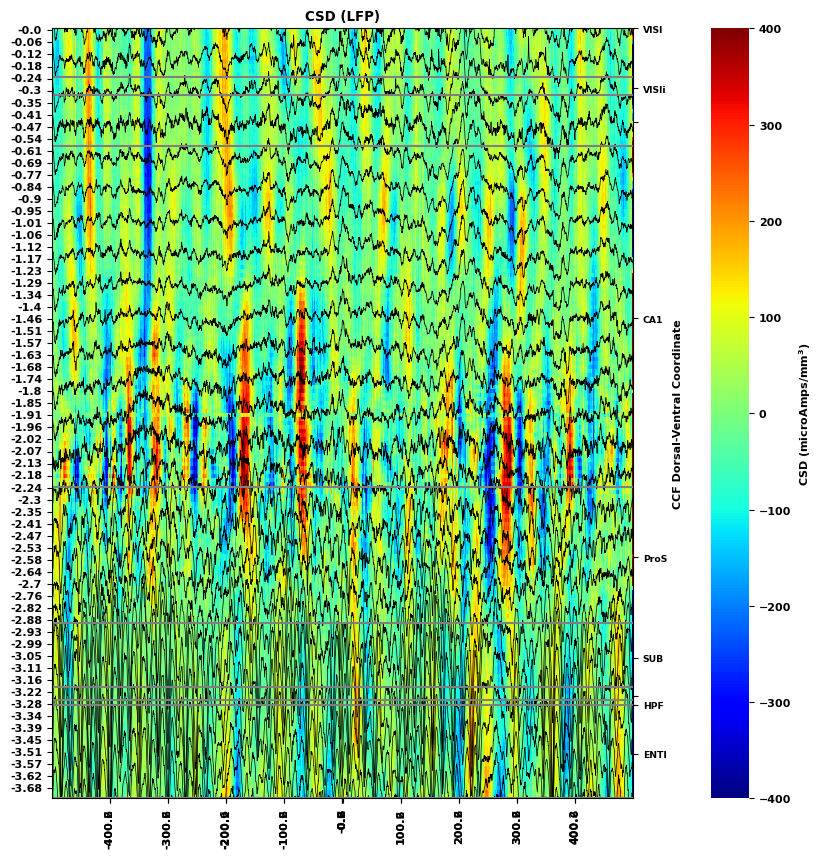

In [107]:
offset = 0.5
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time-offset)) & (lfp_time_index_og <= (desired_event.global_peak_time+offset))

lfp_slice = destriped[:,event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(lfp_slice.T, spacing_between_channels=20, chan_rows =channels['rawInd'])
#time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms*1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0) 
sig = scaled_filtered_smoothed_csd.shape[1] / 10.0  # Proportional to the size of the array
# Apply Gaussian smoothing
#scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
#scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
#scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
#scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-400] = -400

#ibl coordinates and ABI region annotiation
collectionname = f'alf/{probe_name}/pykilosort' # ensures channels are all from this probe
channels = one.load_object(session_id, 'channels', collection=collectionname)
channels.allen2017_25um_acronym = br.id2acronym( channels['brainLocationIds_ccf_2017'] )

# for computing depth from surface
ssl = SpikeSortingLoader(pid=desired_event.peak_probe, one=one, atlas=ba)
channels_ssl = ssl.load_channels()
xyz = np.c_[channels_ssl['x'], channels_ssl['y'], channels_ssl['z']]


ccf_dorsal_ventral = channels['mlapdv'][:,2]
ccf_dorsal_ventral = ccf_dorsal_ventral*-1
allen_ontology_annot_og = channels['allen2017_25um_acronym']
mask = np.full(current_sink_this_rip.shape[1]*2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
#ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask] 
# simplify the names...
allen_ontology_annot = ['' if s.islower() else 'VISl' if 'VISl' in s and not 'VISli' in s else 'VISli' if 'VISli' in s else 'ENTl' if 'ENTl' in s else s for s in allen_ontology_annot]
indices = np.char.find(allen_ontology_annot_og.astype(str), 'VIS')
surface_index = np.where(indices != -1)[0].max()
surface_of_cortex = xyz[surface_index,2]
depth_of_first_cortical_channel_mm = surface_of_cortex - xyz[mask,2]  
depth_of_first_cortical_channel_mm = (-1*1000*depth_of_first_cortical_channel_mm) # making it negative and in mm not microns
depth_of_first_cortical_channel_mm = np.flip(np.round(depth_of_first_cortical_channel_mm, 2))
depth_of_first_cortical_channel_mm = [str(x) for x in depth_of_first_cortical_channel_mm]

#allen_ontology_annot = np.flip(allen_ontology_annot)
#allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen/10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen/10), dtype=int)

#plt.rcParams['svg.fonttype'] = 'none'
#plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
#plt.rcParams["font.weight"] = "bold"
#plt.rcParams["font.size"] = 8
#plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
#plt.rcParams["axes.labelweight"] = "bold"

plt.figure(figsize=(10*offset*2, 10))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
#scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.index = depth_of_first_cortical_channel_mm
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

# Add your heatmap code here
heatmap = sns.heatmap(scaled_filtered_smoothed_csd, cbar_kws={'pad': 0.1}, fmt=".2f", cmap="jet") #"Spectral_r" or "vlag" # RdYlBu_r


# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 8
trace_arr = lfp_slice[1::nth_probe]  

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

# Compute the median for each row in the DataFrame
trace_medians = np.median(trace_arr, axis=1)

for i, trace in enumerate(trace_arr):
    
    # Subtract the median from the trace
    trace = trace - trace_medians[i]
    
    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = trace + i * nth_probe  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color='black', linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot)) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize='small')
ax2.set_ylabel("Cortical depth")  # Add y-axis label on the right


# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color='grey')

plt.title("CSD (LFP)")
plt.xlabel("Time from ripple center time (ms)")
#plt.ylabel("CCF Dorsal-Ventral Coordinate")
label = plt.ylabel("CCF Dorsal-Ventral Coordinate")
label.set_position((2, 0.5))

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm$^3$)")

# Calculate the positions for x-ticks that are multiples of 100
x_tick_positions = [i for i, x in enumerate(time_ripple_centered_ms) if int(x) % 100 == 0]

# Set the x-ticks to these positions
plt.xticks(ticks=x_tick_positions, labels=[time_ripple_centered_ms[i] for i in x_tick_positions])

#filepathandname = '/home/acampbell/NeuropixelsLFPOnRamp/TechnicalValidation/figures/figure1/figure_three_d_2.svg'
#plt.savefig(filepathandname, format='svg')
filepathandname = '/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure_one_d_2.jpg'
#plt.savefig(filepathandname, format='jpg', dpi=300)
plt.show()

## Making Brain Images of Probes

Using this code you can take snapshots of the probe locations in 

https://community.brain-map.org/t/how-to-switch-between-the-3-coordinate-systems-of-mouse-connectivity/952 <br>
https://community.brain-map.org/t/how-to-transform-ccf-x-y-z-coordinates-into-stereotactic-coordinates/1858

In [111]:
seshes = os.listdir('/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024')
seshes = [s.replace('swrs_session_', '') for s in seshes if 'swrs_session_' in s]
seshes = [int(s) for s in seshes]



In [112]:

import random
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import vedo
from brainrender import Scene
from brainrender.actors import Points
from vedo import Plotter  # <- this will be used to render an embedded scene 
#from vedo import embedWindow    
vedo.settings.default_backend= 'k3d'

from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions

ba = AllenAtlas()
br = BrainRegions() # br is also an attribute of ba so could to br = ba.regions


In [113]:
def coords_transform(ml, ap,  dv,  resolution=25):
    
    ml_ccf = (ml+5700)
    #ap_ccf = ((-1)*ap + 5400)/resolution
    ap_ccf = -ap+4700
    dv_ccf = -dv
    
    
    return ml_ccf, ap_ccf, dv_ccf

In [114]:
# Display the Allen Brain mouse atlas.
scene = Scene(atlas_name="allen_mouse_25um", title="Cells in primary visual cortex")
# Make sure it gets embedded in the window
scene.jupyter = True

def get_n_random_points_in_region(region, N):
    """
    Gets N random points inside (or on the surface) of a mes
    """

    region_bounds = region.mesh.bounds()
    X = np.random.randint(region_bounds[0], region_bounds[1], size=10000)
    Y = np.random.randint(region_bounds[2], region_bounds[3], size=10000)
    Z = np.random.randint(region_bounds[4], region_bounds[5], size=10000)
    pts = [[x, y, z] for x, y, z in zip(X, Y, Z)]

    ipts = region.mesh.inside_points(pts).coordinates
    return np.vstack(random.choices(ipts, k=N))


scene = Scene(title="Labelled cells")

# Display a brain region
cornu_Ammonis_1 = scene.add_brain_region("CA1", alpha=0.2)

ca1_coordinates = []

# Iterate over all subdirectories in the base directory
for dir_name in os.listdir(ibl_ripples_path):
    if 'swrs_session_' in dir_name:
        # Extract the session ID from the directory name and get the session data
        session_id = dir_name.split('swrs_session_')[1]
        print(session_id)
        probelist, probenames = one.eid2pid(session_id) # probe_id is pid in the IBL tutorials
        
        # Iterate over all files in the directory
        for file_name in os.listdir(os.path.join(ibl_ripples_path, dir_name)):
            print(file_name)
            ca1_coordinates = []
            if 'karlsson' in file_name:
                # Extract probe_id from the filename
                probe_id = re.search('probe_(.*?)_', file_name).group(1)
                print(probe_id)
                p_idx = np.array([p==probe_id for p in probelist])
                probe_name = np.array(probenames)[p_idx]
                probe_name = probe_name[0]
                collectionname = f'alf/{probe_name}/pykilosort' # ensures channels are all from this probe
                channels = one.load_object(session_id, 'channels', collection=collectionname)
                channels.allen2017_25um_acronym = br.id2acronym( channels['brainLocationIds_ccf_2017'] )
                ca1index = channels['allen2017_25um_acronym'] == 'CA1'
                # Get the coordinates for all CA1 channels specific to the probe_id
                ca1_coordinates = channels['mlapdv'][ca1index]
                transformed_coordinates = np.array([coords_transform(ml, ap, dv, resolution=25) for ml, ap, dv in ca1_coordinates])
                
                # rearanging it so that it can be plotted 
                transformed_coordinates = np.take(transformed_coordinates, [1, 2, 0], axis=1)
                
                # Extract the dorsal_ventral_ccf_coordinate values
                dorsal_ventral_values = transformed_coordinates[:,1]
                
                # Sort the values
                sorted_values = np.sort(dorsal_ventral_values)

                # Calculate the mid-point
                mid_point_value = sorted_values[len(sorted_values) // 2]

                # Find the row with the mid-point value
                mid_point_row = transformed_coordinates[np.where(transformed_coordinates[:, 1] == mid_point_value)]

                scene.add(
                    Points(
                        mid_point_row,
                        name="probe_1",
                        colors="black",
                        radius=100,
                    )
                )
            
# Add label to the brain region
scene.add_label(cornu_Ammonis_1, "CA1")

# render
scene.content
scene.render()

plt = Plotter()
plt.show(*scene.renderables)

0cc486c3-8c7b-494d-aa04-b70e2690bcba
probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_366_karlsson_detector_events.csv
db2100c3-64ac-463e-97a1-20ce8266cd5f
session_0cc486c3-8c7b-494d-aa04-b70e2690bcba_putative_global_swrs_no_movement.csv
probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_138_movement_artifacts.csv
probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_319_movement_artifacts.csv
session_0cc486c3-8c7b-494d-aa04-b70e2690bcba_putative_global_swrs_no_movement_no_gamma.csv
probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_366_gamma_band_events.csv
746d1902-fa59-4cab-b0aa-013be36060d5
probe_e31b4e39-e350-47a9-aca4-72496d99ff2a_channel_channelsrawInd_351_movement_artifacts.csv
session_746d1902-fa59-4cab-b0aa-013be36060d5_putative_global_swrs_no_movement.csv
session_746d1902-fa59-4cab-b0aa-013be36060d5_putative_global_swrs_no_movement_no_gamma.csv
probe_e31b4e39-e350-47a9-aca4-72496d99ff2a_channel_channelsrawInd_383_gam

probe_9e44ddb5-7c7c-48f1-954a-6cec2ad26088_channel_channelsrawInd_234_gamma_band_events.csv
c7bf2d49-4937-4597-b307-9f39cb1c7b16
probe_e49f221d-399d-4297-bb7d-2d23cc0e4acc_channel_channelsrawInd_225_karlsson_detector_events.csv
e49f221d-399d-4297-bb7d-2d23cc0e4acc


/home/acampbell/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.0kB/s]
/home/acampbell/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 24.0kB/s]


probe_e49f221d-399d-4297-bb7d-2d23cc0e4acc_channel_channelsrawInd_166_movement_artifacts.csv
session_c7bf2d49-4937-4597-b307-9f39cb1c7b16_putative_global_swrs_no_movement.csv
probe_e49f221d-399d-4297-bb7d-2d23cc0e4acc_channel_channelsrawInd_225_gamma_band_events.csv
probe_e49f221d-399d-4297-bb7d-2d23cc0e4acc_channel_channelsrawInd_131_movement_artifacts.csv
session_c7bf2d49-4937-4597-b307-9f39cb1c7b16_putative_global_swrs_no_movement_no_gamma.csv
b03fbc44-3d8e-4a6c-8a50-5ea3498568e0
session_b03fbc44-3d8e-4a6c-8a50-5ea3498568e0_putative_global_swrs_no_movement_no_gamma.csv
probe_9117969a-3f0d-478b-ad75-98263e3bfacf_channel_channelsrawInd_257_karlsson_detector_events.csv
9117969a-3f0d-478b-ad75-98263e3bfacf
session_b03fbc44-3d8e-4a6c-8a50-5ea3498568e0_putative_global_swrs_no_movement.csv
probe_9117969a-3f0d-478b-ad75-98263e3bfacf_channel_channelsrawInd_306_movement_artifacts.csv
probe_9117969a-3f0d-478b-ad75-98263e3bfacf_channel_channelsrawInd_257_gamma_band_events.csv
probe_9117969a-3f0

Cannot run function add_label in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

╭─────────────────────────────────╮
│                                 │
│   Scene actors                  │
│   ────────────                  │
│                                 │
│   - root (type: brain region)   │
│   - title (type: title)         │
│   - CA1 (type: brain region)    │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: [38;2

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], backgro…